In [ ]:
#functions defined in the initial cells, experiments are conducted in subsequent cells

In [ ]:
from psutil import *
# This code will return the number of CPU
print("Number of CPU: ", cpu_count())
# This code will return the CPU info
!cat /proc/cpuinfo


In [1]:
# Install Gurobi
!pip install gurobipy

# Upload Gurobi license file
from google.colab import files
uploaded = files.upload()  # Upload your gurobi license file (gurobi.lic)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create base directory if it doesn't exist
import os

base_dir = "/content/drive/MyDrive/clustering_experiments_final"
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    print("Base directory created.")
else:
    print("Base directory already exists.")

# Create image subdirectory if it doesn't exist
base_dir_img = os.path.join(base_dir, "images_final")
if not os.path.exists(base_dir_img):
    os.makedirs(base_dir_img)
    print("Image subdirectory created.")
else:
    print("Image subdirectory already exists.")
global_size= 24
global_font = 14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 50.9 MB/s eta 0:00:00


Saving gurobi.lic to gurobi.lic
Mounted at /content/drive
Base directory already exists.
Image subdirectory already exists.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from re import L
import numpy as np, numpy.random
from scipy.optimize import minimize
from scipy.spatial import ConvexHull
import os
os.environ['GRB_LICENSE_FILE'] = '/content/gurobi.lic'
import gurobipy as gp
from gurobipy import GRB
import time


##Gurobi func. for solving integer linear program, weighted k median
def gurobi_k_median(X, weights, Y, distances, k):
    """
    Solves the k-median problem (integrally) given a fixed set of potential centers X and clients Y.

    Parameters:
    X (list): List of potential facility locations.
    Y (list): List of client locations.
    k (int): Number of facilities to open.
    distance (function): Function distance(a, b) that computes distance between a client and a facility.

    Returns:
    tuple: (selected_centers, assignments) where selected_centers is a list of chosen facility indices,
           and assignments is a dictionary mapping each client index to an open facility index.
    """
    num_facilities = len(X)
    num_clients = len(Y)

    model = gp.Model("k-median")
    model.setParam("OutputFlag", 0)

    # Decision variables
    x = model.addVars(num_clients, num_facilities, vtype=GRB.BINARY, name="assign")
    y = model.addVars(num_facilities, vtype=GRB.BINARY, name="open")

    # Objective: Minimize total assignment cost
    model.setObjective(
        gp.quicksum(weights[i]*distances[Y[i]][X[j]] * x[i, j] for i in range(num_clients) for j in range(num_facilities)),
        GRB.MINIMIZE
    )

    # Constraints
    # Each client must be assigned to exactly one facility
    for i in range(num_clients):
        model.addConstr(gp.quicksum(x[i, j] for j in range(num_facilities)) == 1, f"assign_{i}")

    # Clients can only be assigned to open facilities
    for i in range(num_clients):
        for j in range(num_facilities):
            model.addConstr(x[i, j] <= y[j], f"open_constraint_{i}_{j}")

    # Open exactly k facilities
    model.addConstr(gp.quicksum(y[j] for j in range(num_facilities)) == k, "k_facilities")

    # Solve the model
    model.optimize()

    # Extract solution
    if model.status == GRB.OPTIMAL:

        selected_centers = [j for j in range(num_facilities) if y[j].x > 0.5]
        assignments = {i: next(j for j in range(num_facilities) if x[i, j].x > 0.5) for i in range(num_clients)}
        objective_cost = model.objVal # Get the objective value

        # Dispose of the model to release the license
        model.dispose()

        return selected_centers, assignments, objective_cost
    else:
        # Dispose of the model even if not optimal to release the license
        model.dispose()
        return None, None




##Gurobi func. for solving linear program, weighted k median
def gurobi_frac_k_median(X, weights, Y, distances, k):
    """
    Solves the k-median problem (fractionally) given a fixed set of potential centers X and clients Y.

    Parameters:
    X (list): List of potential facility locations.
    Y (list): List of client locations.
    k (int): Number of facilities to open.
    distance (function): Function distance(a, b) that computes distance between a client and a facility.

    Returns:
    tuple: (selected_centers, assignments) where selected_centers is a list of chosen facility indices,
           and assignments is a dictionary mapping each client index to an open facility index.
    """
    num_facilities = len(X)
    num_clients = len(Y)

    model = gp.Model("k-median")
    model.setParam("OutputFlag", 0)

    # Decision variables
    x = model.addVars(num_clients, num_facilities, vtype=GRB.CONTINUOUS, name="assign")
    y = model.addVars(num_facilities, vtype=GRB.CONTINUOUS, name="open")

    for i in range(num_clients):
       for j in range(num_facilities):
           x[i, j].UB = 1  # Set upper bound for x variables

    for j in range(num_facilities):
         y[j].UB = 1  # Set upper bound for y variables


    # Objective: Minimize total assignment cost
    model.setObjective(
        gp.quicksum(weights[i]*distances[Y[i]][X[j]] * x[i, j] for i in range(num_clients) for j in range(num_facilities)),
        GRB.MINIMIZE
    )

    # Constraints
    # Each client must be assigned to exactly one facility
    for i in range(num_clients):
        model.addConstr(gp.quicksum(x[i, j] for j in range(num_facilities)) == 1, f"assign_{i}")

    # Clients can only be assigned to open facilities
    for i in range(num_clients):
        for j in range(num_facilities):
            model.addConstr(x[i, j] <= y[j], f"open_constraint_{i}_{j}")

    # Open exactly k facilities
    model.addConstr(gp.quicksum(y[j] for j in range(num_facilities)) == k, "k_facilities")

    # Solve the model
    model.optimize()

    # Extract solution
    if model.status == GRB.OPTIMAL:
        y_values = []
        for j in range(num_facilities):
          y_values.append(y[j].x)
        objective_cost = model.objVal # Get the objective value
        return y_values, objective_cost
    else:
        return None, None



##func. for computing cost of OPT over time
def exp_gurobi_benchmark(instance_list,weight_list,ground_set,distances,k):
  cost = 0
  weights,instance = gurobi_transformer(weight_list,instance_list)
  selected_centers,assignments,gurobi_total_cost =  gurobi_k_median(ground_set,weights,instance,distances,k)
  gurobi_opt = [ground_set[i] for i in selected_centers]
  gurobi_cost_over_time = []
  for i in range(len(instance_list)):
    if(i!=0):
     cost+= k_median_int_cost(instance_list[i],[1]*len(instance_list[i]),gurobi_opt)/weight_list[i]
     gurobi_cost_over_time.append(cost)
  return gurobi_opt,gurobi_cost_over_time




##func. for computing cost of fractional OPT for the history so far
def exp_gurobi_frac_benchmark(instance_list,weight_list,ground_set,distances,k):
  cost = 0
  weights,instance = gurobi_transformer(weight_list,instance_list)

  y_vals,gurobi_total_cost =  gurobi_frac_k_median(ground_set,weights,instance,distances,k)
  return [[ground_set[i],y_vals[i]] for i in range(len(ground_set))],gurobi_total_cost



##func. for computing weights of points in the k-median instance for gurobi
def gurobi_transformer(weight_list,instance_list):
  dict = {}
  for instance_index in range(len(instance_list)):
    instance = instance_list[instance_index]
    for i in range(len(instance)):
      if(instance[i] not in dict):
        dict[instance[i]] = 0
      if(instance_index!=0):
        dict[instance[i]]+=1/weight_list[instance_index]
  weights = []
  instance = []
  for i in dict:
    weights.append(dict[i])
    instance.append(i)
  return weights,instance




##helper func. for computing projections
def custom_project_helper2(i,n,y_store,beta,k,k_):
      l = -y_store[i]
      r = max(-y_store[i]+ k_ + 1e-6,1)
      #print("help!",r)
      if(i!=0):
        r = min(r,-y_store[i-1])
      tol = 10000000
      lam = 0
      x_arr = 0
      cnt  = 0
      while( (abs(tol)<1e-9 and tol<0) or abs(tol)>1e-9 ):
        #print("umm",tol,l,r)
        cnt+=1
        mid = (l+r)/2
        x_arr = [beta*np.sinh(mid + y_store[j]) if j >= i else 0 for j in range(n)]

        total = sum(x_arr)
        if(total > k):
          r = mid
        else:
          l = mid
        lam = mid
        tol = total-k
      return x_arr


##func. for computing projections
def custom_project_strong(beta,y,k):
  n = len(y)
  proxy_y = [ [y[i],i] for i in range(n)]
  proxy_y.sort()
  y_store = [np.arcsinh(proxy_y[j][0]/beta) for j in range(n)]

  current_best = -1
  flag = 0
  l = 0
  r = n-1
  while(flag == 0):
    mid = (l+r)//2
    lam = -y_store[mid]
    tol = sum([beta*np.sinh(lam + y_store[j]) if j>=mid else 0 for j in range(n)])
    if(tol <=k):
      r = mid
    else:
      l = mid+1
    if(l==r):
      flag = 1
      current_best  =l
  k_ = np.arcsinh(k)
  x_arr = custom_project_helper2(current_best,n,y_store,beta,k,k_)
  factor = k/sum(x_arr)
  ans = [0]*n
  for j in range(n):
          ans[proxy_y[j][1]] = x_arr[j]*factor
  return ans



##func. for computing bregman divergence
def hypentropy_divergence(beta,x,y):
  sum = 0
  n = len(x)
  for i in range(n):
    sum+= x[i]*(np.arcsinh(x[i]/beta) - np.arcsinh(y[i]/beta)) -  (x[i]**2 + beta**2)**0.5  + (y[i]**2 + beta**2)**0.5
  return sum



##helper func. for computing mirror descent step
def OMD_step(y,R,t,k):
  d =  len(y)
  y_vals = [0]*len(y)
  for i in range(d):
    y_vals[i] = y[i][1]

  subgradient = compute_subgradient(y,R,d)
  x = subgradient_step(y_vals,subgradient,t)
  y_vals = custom_project_strong(1/len(x),x,k)
  y_sum = sum(y_vals)
  return [ [y[i][0],(y_vals[i] *k)/y_sum ]  for i in range(d) ]




##func. for making balls around the initial filtered centers in randomized rounding
def bundle_maker(matching,serving_centers,radii,k,allowed_set):
  assigned = {}
  bundles = []
  #print("check",allowed_set)
  global distances
  for i in range(len(matching)):
    if(len(matching[i]) ==2):
      bundle1 = []
      bundle2 = []

      for j in range(len(serving_centers[2*i])):

        if(distances[matching[i][0]][serving_centers[2*i][j][0]] < radii[2*i]  ):
          assigned[serving_centers[2*i][j][0]]=1
          bundle1.append([serving_centers[2*i][j][0],serving_centers[2*i][j][1]] )
      for j in range(len(serving_centers[2*i+1])):
        if(distances[matching[i][1]][serving_centers[2*i+1][j][0]] < radii[2*i+1]  ):
          assigned[serving_centers[2*i+1][j][0]]=1
          bundle2.append([serving_centers[2*i+1][j][0],serving_centers[2*i+1][j][1]] )
      bundles.append(bundle1)
      bundles.append(bundle2)
    else:
      bundle1 = []
      for j in range(len(serving_centers[2*i])):
        if(distances[matching[i][0]][serving_centers[2*i][j][0]] < radii[2*i]  ):
                  assigned[serving_centers[2*i][j][0]]=1
                  bundle1.append([serving_centers[2*i][j][0],serving_centers[2*i][j][1]] )
      bundles.append(bundle1)
  non_bundled = []
  for i in range(len(allowed_set)):
    if(allowed_set[i][0] not in assigned):
      non_bundled.append([allowed_set[i][0],allowed_set[i][1]])

  return bundles,non_bundled




##func. for randomized rounding
def rand_rounding(y,k):

  filtered_centers,matching,bundles,non_bundled = rand_filter(y,k)
  indicator = line_based_rounding(bundles,non_bundled)
  opened = bundle_opener(matching, bundles, non_bundled, indicator)

  opened_dupes_fixed = []
  for i in opened:
    if(i not in opened_dupes_fixed):
      opened_dupes_fixed.append(i)
  cnt = 0
  while(len(opened_dupes_fixed)<k):
    if(y[cnt][0] not in opened_dupes_fixed):
      opened_dupes_fixed.append(y[cnt][0])
    cnt+=1
  return opened_dupes_fixed


##func. for initial filtration step in randomized rounding
def rand_filter(y,k):
  global dict_used
  global distances_sorted
  n = len(y)
  fractional_costs = [0]*n
  for i in range(n):
    cnt  = 0
    sum_i = 0
    for j in range(len(distances_sorted)):
      if(cnt == 1):
          break
      center = distances_sorted[y[i][0]][j][1]
      center_dist =  distances_sorted[y[i][0]][j][0]

      if(center in dict_used):
       sum_i+= min(1-cnt,y[dict_used[center]][1])*center_dist
       cnt+= min(1-cnt,y[dict_used[center]][1])
    fractional_costs[i] = [sum_i,i,y[i][0]]

  fractional_costs.sort()
  filtered_centers,matching,bundled,non_bundled = rand_heuristic(y,fractional_costs,k)
  return filtered_centers,matching,bundled,non_bundled



##func. using heuristic for randomized rounding
def rand_heuristic(y,fractional_costs,k):
  n = len(y)
  filtered_centers = []
  matching = 0
  bundles = 0
  non_bundled = 0
  lfactor = 1
  rfactor = 4
  flag = 0

  while(flag == 0):
    temp_centers = []
    mid = (lfactor+rfactor)/2
    for i in range(n):
      min_dist_val,min_dist_index = min_dist(y[fractional_costs[i][1]][0],temp_centers)
      if(min_dist_val > mid*fractional_costs[i][0]):
        temp_centers.append(y[fractional_costs[i][1]][0])
    temp_matching = matching_(temp_centers)
    serving_centers,radii, allowed_set = setify(temp_matching,y,k)
    temp_bundles,temp_non_bundled= bundle_maker(temp_matching,serving_centers,radii,k,allowed_set)
    local_flag = 0
    for bundle in temp_bundles:
      if(bundle_check(bundle) == 0):
        local_flag = 1
        break
    if(local_flag == 0):
      rfactor = mid
      filtered_centers = temp_centers
      matching = temp_matching
      bundles = temp_bundles
      non_bundled = temp_non_bundled
    else:
      lfactor = mid
    if(np.abs(lfactor - rfactor) < 0.01):
      flag = 1
    if(np.abs(lfactor - rfactor) <  0.01 and matching == 0):
      flag = 0
      rfactor = 4
      lfactor = 4
  return filtered_centers,matching,bundles,non_bundled



##func. for checking if a ball has mass at least 1/2 in randomized rounding (useful for heuristic)
def bundle_check(bundle):
  n = len(bundle)
  sum1 = 0
  for i in range(n):
    sum1+=bundle[i][1]
  if(sum1 >= 0.5 + 1e-9):
    return 1
  else:
    return 0



##func. for creating matching after initial filtration step in randomized rounding
def matching_(y):
  n = len(y)
  global distances
  distances_ = []
  for i in range(n):
    for j in range(n):
      if(j != i):
        distances_.append([distances[y[i]][y[j]],[i,j]])

  distances_.sort()
  matched = [0]*n
  matching = []
  total_matched = 0
  cnt = 0
  while(total_matched <n-1):
    if(matched[distances_[cnt][1][0]] == 0 and matched[distances_[cnt][1][1]] == 0 ):
      matched[distances_[cnt][1][0]] = 1
      matched[distances_[cnt][1][1]] = 1
      i = distances_[cnt][1][0]
      j = distances_[cnt][1][1]
      matching.append([y[i],y[j]])
      total_matched+=2
    cnt+=1
  for i in range(n):
    if(matched[i] == 0):
      matching.append([y[i]])
  return matching



##func. for deciding the radii of balls after initial filtration step in randomized rounding + finding out the points that serve the points in the matching in the fractional soluion
def setify(matching,y,k):
  global distances
  n = len(matching)
  if(len(matching[-1]) == 1):
    n = 2*(n-1) +1
  else:
    n = 2*n
  matching_unrolled = []
  for i in range(len(matching)):
    for j in range(len(matching[i])):
      matching_unrolled.append(matching[i][j])

  serving_centers_unrolled = [0]*n
  for i in range(n):
    serving_centers_unrolled[i] = []
  radii = []
  allowed_set = []
  for j in range(len(y)):
    allowed_set.append([y[j][0],y[j][1]])
  allocations = np.zeros((n,len(y)))
  allocation_cnt = 0
  for i in range(len(matching)):
    for j in range(len(matching[i])):
      dist_i = []
      matchdist_i = 10000000000000000000000000000000
      for u in range(len(y)):

          dist_i.append([distances[matching[i][j]][y[u][0]],u])
      for u in range(len(matching_unrolled)):
        if(matching[i][j]!=matching_unrolled[u]):

         dist1= distances[matching[i][j]][matching_unrolled[u]]
         if(dist1 < matchdist_i):
          matchdist_i = dist1
      dist_i.sort()
      radii.append(0.5*matchdist_i)
      cnt  = 0
      for u in range(len(dist_i)):
          if(cnt == 1):
            break
          center = dist_i[u][1]
          center_dist =  dist_i[u][0]
          allocations[allocation_cnt][center] = min(1-cnt,y[center][1])
          cnt+= min(1-cnt,y[center][1])

      allocation_cnt+=1

  for i in range(n):
    for j in range(len(y)):
      if(allocations[i][j] > 0):
        serving_centers_unrolled[i].append([y[j][0], allocations[i][j] ])
  #print("allowed",allowed_set)
  return serving_centers_unrolled,radii, allowed_set



##func. for deciding which centers to open after initial filtration step in randomized rounding
def line_based_rounding(bundles,non_bundled):
  probabilities = []
  for i in range(len(bundles)):
    sum_i = 0
    for j in range(len(bundles[i])):
      sum_i+= bundles[i][j][1]
    probabilities.append(sum_i)
  #print("linecheck1",sum(probabilities))
  for i in range(len(non_bundled)):
    probabilities.append(non_bundled[i][1])
  #print("linecheck2",sum(probabilities))
  return line_rounding(probabilities)



##helper func. for deciding which centers to open after initial filtration step in randomized rounding
def line_rounding(probabilities):
  r = np.random.rand()
  n = len(probabilities)
  indicator = [0]*n
  sum_so_far = 0
  for i in range(n):
    index = np.ceil(sum_so_far - r)
    if(index + r <= sum_so_far + probabilities[i]):
      indicator[i] = 1
    sum_so_far+= probabilities[i]
  return indicator




##func. that opens the centers indicated by the line based rounding
def bundle_opener(matching, bundles, non_bundled, indicator):
  opened = []
  cnt = 0
  for i in range(len(matching)):
    for j in range(len(matching[i])):
      if(indicator[cnt] == 1):
        opened.append(matching[i][j])
      cnt+=1

  for i in range(len(non_bundled)):
    if(indicator[cnt] ==1):
      opened.append(non_bundled[i][0])
    cnt+=1

  return opened


##func. for heuristic in deterministic algorithm
def det_heuristic(y,fractional_costs,k):
    n = len(y)
    l = 1
    r = 2*k+2
    best_filter = 0
    best_indices = []
    flag = 0
    while(flag == 0):
          filtered_centers = []
          filter_indices = [0]*n
          mid = (l+r)/2
          for i in range(n):
            min_dist_val,min_dist_index = min_dist(y[fractional_costs[i][1]][0],[y[u][0] for u in filtered_centers])
            if(min_dist_val > mid*fractional_costs[i][0]):
                    filtered_centers.append(fractional_costs[i][1])
                    filter_indices[i] = 1
          if(len(filtered_centers)<=k):
             r = mid
             best_filter = filtered_centers
             best_indices = filter_indices
          else:
             l = mid
          if(r-l <0.01):
            flag = 1
          if(r - l < 0.01 and best_filter == 0):
            flag = 0
            r= 2*k+2
            l = 2*k+2


    return best_filter,best_indices


##func. for deterministic rounding
def det_rounding(y,k):
  global dict_used
  global distances_sorted
  n = len(y)
  fractional_costs = [0]*n
  time1 = time.time()
  for i in range(n):
    cnt  = 0
    sum_i = 0
    for j in range(len(distances_sorted)):
      if(cnt == 1):
          break
      center = distances_sorted[y[i][0]][j][1]
      center_dist =  distances_sorted[y[i][0]][j][0]

      if(center in dict_used):
       sum_i+= min(1-cnt,y[dict_used[center]][1])*center_dist
       cnt+= min(1-cnt,y[dict_used[center]][1])
    fractional_costs[i] = [sum_i,i,y[i][0]]

  fractional_costs.sort()
  filtered_centers,filter_indices = det_heuristic(y,fractional_costs,k)

  if(len(filtered_centers) <k):

    cnt = 0
    while(len(filtered_centers) <k):
      if(filter_indices[cnt]==0):
        filtered_centers.append(fractional_costs[cnt][1])
        filter_indices[cnt] = 1
      cnt+=1

  return [y[filtered_centers[i]][0] for i in range(k)]




##func. for outputting deterministic soln. for a round
def det_online_k_median(instance,y,t,k):
  global dict_used
  if(t==0):
    weights,local_opt = transformer(instance,k)
    y = []
    for i in local_opt:
      dict_used[i] = len(y)
      y.append([i,1])
    return y, local_opt
  else:
    weights,local_opt = transformer(instance,k)
    for i in local_opt:
      if(i not in dict_used):
        dict_used[i] = len(y)
        y.append([i,0])
    y = OMD_step(y,list(zip(local_opt,weights)),t,k)
    alg_output = det_rounding(y,k)
    return y, alg_output

##func. for outputting randomized soln. for a round
def rand_online_k_median(instance,y,t,k):
  global dict_used
  if(t==0):
    weights,local_opt = transformer(instance,k)
    y = []
    for i in local_opt:
      dict_used[i] = len(y)
      y.append([i,1])
    return y, local_opt
  else:
    weights,local_opt = transformer(instance,k)
    for i in local_opt:
      if(i not in dict_used):
        dict_used[i] = len(y)
        y.append([i,0])

    y = OMD_step(y,list(zip(local_opt,weights)),t,k)
    alg_output = rand_rounding(y,k)

    return y, alg_output


##func. for the subgradient step in OMD (calculating x_{t+1} from y_t)
def subgradient_step(y,gradient,t):
  global max_grad
  d = len(gradient)
  x = [0]*d
  max1 = -100000000000000000000
  for i in range(d):
    max1 = max(max1,np.abs(gradient[i]))
  max_grad = max(max1,max_grad)
  if(max_grad==0):
    return y
  eta = 1/(max_grad*(t**0.5))
  for i in range(d):
    if(i < len(y)):
      x[i] = np.sinh(np.arcsinh(d*y[i])  - eta*gradient[i])/d
    else:
      x[i]  = np.sinh(-eta*gradient[i])/d
  return x



##func. for computing subgradient
def compute_subgradient(y,R,d):
  subgradient = [0]*d
  global dict_used
  global distances_sorted
  for x in range(len(R)):
    weight = R[x][1]
    sorter = []
    distances_ = []
    sum = 0
    max_dist = 0
    for i in range(len(distances_sorted)):
      center = distances_sorted[R[x][0]][i][1]
      if(center in dict_used ):
        frac = y[dict_used[center]][1]
        max_dist = max(max_dist,distances_sorted[R[x][0]][i][0])
        sum+= frac
        if(sum >=1):
          break
    sum = 0
    cnt = 0
    for i in range(len(distances_sorted)):
      center = distances_sorted[R[x][0]][i][1]
      if(center in dict_used ):
        frac = y[dict_used[center]][1]
        subgradient[dict_used[center]]+= -weight*(max_dist -distances_sorted[R[x][0]][i][0] )
        sum+= frac
        if(sum >=1):
          break

  return subgradient


## euclidean metric
def dist(a,b):
  n = len(a)
  sum = 0
  for i in range(n):
    sum+=(a[i]-b[i])**2
  sum = sum**0.5
  return sum



#func. for distance in the metric space
def dist_metric(i,j):
  return dist(metric_space[i],metric_space[j])


# exponential exact k-median algorithm
def optimal_kmedian(I,k):
    min_cost = float('inf')
    best_centers = None
    weights = [1]*len(I)
    for centers in combinations(I, k):  # Generate all subsets of k centers

        cost = k_median_int_cost(I,weights, centers)  # Compute k-median cost for this subset
        if cost < min_cost:
            min_cost = cost
            best_centers = centers  # Store best centers

    return best_centers,min_cost



#func that finds the cost of a given k median integral solution
def k_median_int_cost(instance,weights,y):
  global distances
  cost = 0
  for i in range(len(instance)):
    dist_i = []
    sum_i = 1000000000000000000
    for j in range(len(y)):
      if(distances[instance[i]][y[j]] < sum_i):
        sum_i = distances[instance[i]][y[j]]
    cost += weights[i] * sum_i
  return cost


#func. that computes the minimum distance from a point to a set (useful in the filtration steps of rounding)
def min_dist(a,B):
  global distances
  min_dist = 10000000000000000000
  min_i = 0
  for i in range(len(B)):
      cand_dist = distances[a][B[i]]
      if( min_dist >  cand_dist  ):
        min_dist = cand_dist
        min_i = i

  return min_dist,min_i




#func that computes the initial reduction step in the algorithm
def transformer(I,k):
  global ground_set
  local_opt = localsearch(I,k)

  weights = [0]*k
  local_opt_cost = k_median_int_cost(I,[1]*len(I),local_opt)
  for i in I:
    closest_center = min_dist(i,local_opt)[1]
    weights[closest_center]+=1
  for i in range(k):
    weights[i]=weights[i]/local_opt_cost
  return weights, local_opt





#func that finds an O(1) approximation for the optimum of the current instance using local search
def localsearch(I,k):
  eps = 0.01
  n = len(I)
  weights = [1]*len(I)
  if(len(I)<= k):
    return None
  solution = [i for i in range(k)]  ### indexes w.r.t I
  solution_bool = [0]*len(I) ## boolean w.r.t I
  for i in range(k):
    solution_bool[i] = 1

  flag = 0

  while flag == 0:
    local_flag = 0
    formatted_solution = [I[i] for i in solution]   ###unique_id
    old_cost = k_median_int_cost(I,weights,formatted_solution)
    for j in range(k):
      for swap in range(n):
        if(solution_bool[swap]==0):
          new_solution = []
          for t in range(k):
            if t==j:
              new_solution.append(swap)
            else:
              new_solution.append(solution[t])
          new_formatted_solution = [I[i] for i in new_solution]
          new_cost = k_median_int_cost(I,weights, new_formatted_solution)
          if(new_cost < old_cost*(1 - eps/k)):
            local_flag = 1
            solution = new_solution
            solution_bool[swap] = 1
            solution_bool[solution[j]] = 0
            old_cost = new_cost
            continue
    if(local_flag == 0):
        flag = 1
  return [I[solution[i]] for i in range(k)]



#func that finds the cost of a given k median (fractional) solution
def k_median_cost(instance,weights,y):
  cost = 0
  global distances
  for i in range(len(instance)):
    dist_i = []
    sum_i=0
    for j in range(len(y)):
      if(y[j][1]!=0):
        dist_i.append([distances[instance[i]][y[j][0]],j])
    dist_i.sort()
    cnt  = 0
    for j in range(len(dist_i)):
      if(cnt == 1):
          break
      center = dist_i[j][1]
      center_dist =  dist_i[j][0]
      sum_i+= min(1-cnt,y[center][1])*center_dist
      cnt+= min(1-cnt,y[center][1])
    cost+=weights[i]*sum_i
  return cost



In [5]:
def uniform_square(n,k,max_per_round,T,seed,seed_rands):
  global metric_space
  global points_used
  global dict_used
  global distances
  global distances_sorted
  global max_grad
  max_grad = 0

  np.random.seed(seed)
  # Sample n points uniformly at random from the unit square
  metric_space = np.random.rand(n, 2)  # shape: (n, 2)
  selected_points_list = [0]*T
  for i in range(T):
    num_points = max_per_round
    selected_indices = np.random.choice(n, num_points, replace=False)  # Pick those many unique points
    selected_points_list[i] = selected_indices

  selected_points_history = []

  cost = 0
  costs = [0]*(len(seed_rands))
  frac_cost = 0
  y = 0
  points_used = [0]*n
  dict_used = {}
  alg_output = 0
  alg_outputs = 0
  instance_list = []
  alg_cost_over_time = []
  alg_costs_over_time = [0]*len(seed_rands)
  alg_output_over_time = []
  alg_outputs_over_time =  [0]*len(seed_rands)
  for i in range(len(seed_rands)):
    alg_costs_over_time[i],alg_outputs_over_time[i] = [],[]

  y_output_over_time = []
  frac_cost_over_time = []
  instance_count = [0]*400
  ground_set = [i for i in range(n)]
  distances = [[dist_metric(y, x) for x in ground_set] for y in ground_set]
  distances_sorted = [0]*n
  for i in range(n):
    temp_arr = [[distances[i][j],j] for j in range(n)]
    temp_arr.sort()
    distances_sorted[i] = temp_arr
  weight_list = []

  for t in range(T):
      if(t%50 ==0):
        print("time",t,k)
      num_points = max_per_round
      selected_indices = selected_points_list[t] # Pick those many unique points
      #if(t>10):
      #  selected_indices = [2*i+t%2 for i in range(10)]
      instance_list.append(selected_indices)
      selected_points_history.append(metric_space[selected_indices])
      weights = [1]*len(selected_indices)
      selected_centers,assignments,local_opt_cost =  gurobi_k_median(ground_set,weights,selected_indices,distances,k)
      gurobi_opt = [ground_set[i] for i in selected_centers]
      weight_list.append(local_opt_cost)

      if(t==0):
          y,alg_output = det_online_k_median(selected_indices,y,t,k)
          alg_outputs = [alg_output]*len(seed_rands)
      else:
            local_alg_cost = k_median_int_cost(selected_indices,weights,alg_output)
            local_frac_cost =   k_median_cost(selected_indices,weights,y)
            cost+= local_alg_cost/local_opt_cost
            frac_cost+= local_frac_cost/local_opt_cost

            alg_cost_over_time.append(cost)
            frac_cost_over_time.append(frac_cost)
            y_output_over_time.append(y)
            alg_output_over_time.append(alg_output)

            for i in range(len(seed_rands)):
                local_alg_cost = k_median_int_cost(selected_indices,weights,alg_outputs[i])
                costs[i]+= local_alg_cost/local_opt_cost
                alg_costs_over_time[i].append(costs[i])
                alg_outputs_over_time[i].append(alg_outputs[i])

            y,alg_output = det_online_k_median(selected_indices,y,t,k)
            for i in range(len(seed_rands)):
                np.random.seed(seed_rands[i])
                alg_outputs[i] = rand_rounding(y,k)

  gurobi_opt,gurobi_cost_over_time = exp_gurobi_benchmark(instance_list,weight_list,ground_set,distances,k)
  # Save files into the base directory with the "uniform_" prefix
  np.save(f"{base_dir}/uniform_selected_points_history_{k}_0_{seed}_{seed}.npy", selected_points_history)
  np.save(f"{base_dir}/uniform_alg_output_{k}_0_{seed}_{seed}.npy", alg_output)
  np.save(f"{base_dir}/uniform_gurobi_opt_{k}_0_{seed}_{seed}.npy", gurobi_opt)
  np.save(f"{base_dir}/uniform_metric_space_{k}_0_{seed}_{seed}.npy", metric_space)
  np.save(f"{base_dir}/uniform_alg_output_over_time_{k}_0_{seed}_{seed}.npy", alg_output_over_time)
  np.save(f"{base_dir}/uniform_y_output_over_time_{k}_0_{seed}_{seed}.npy", np.array(y_output_over_time, dtype=object), allow_pickle=True)
  np.save(f"{base_dir}/uniform_alg_cost_over_time_{k}_0_{seed}_{seed}.npy", alg_cost_over_time)
  np.save(f"{base_dir}/uniform_gurobi_cost_over_time_{k}_0_{seed}_{seed}.npy", gurobi_cost_over_time)
  np.save(f"{base_dir}/uniform_frac_cost_over_time_{k}_0_{seed}_{seed}.npy",frac_cost_over_time)
  cnt = 0
  for seed_rand in seed_rands:
    # Save files into the base directory with the "uniform_" prefix
        np.save(f"{base_dir}/uniform_selected_points_history_{k}_1_{seed}_{seed_rand}.npy", selected_points_history)
        np.save(f"{base_dir}/uniform_alg_output_{k}_1_{seed}_{seed_rand}.npy", alg_outputs[cnt])
        np.save(f"{base_dir}/uniform_gurobi_opt_{k}_1_{seed}_{seed_rand}.npy", gurobi_opt)
        np.save(f"{base_dir}/uniform_metric_space_{k}_1_{seed}_{seed_rand}.npy", metric_space)
        np.save(f"{base_dir}/uniform_alg_output_over_time_{k}_1_{seed}_{seed_rand}.npy", alg_outputs_over_time[cnt])
        np.save(f"{base_dir}/uniform_y_output_over_time_{k}_1_{seed}_{seed_rand}.npy", np.array(y_output_over_time, dtype=object), allow_pickle=True)
        np.save(f"{base_dir}/uniform_alg_cost_over_time_{k}_1_{seed}_{seed_rand}.npy", alg_costs_over_time[cnt])
        np.save(f"{base_dir}/uniform_gurobi_cost_over_time_{k}_1_{seed}_{seed_rand}.npy", gurobi_cost_over_time)
        np.save(f"{base_dir}/uniform_frac_cost_over_time_{k}_1_{seed}_{seed_rand}.npy",frac_cost_over_time)
        cnt+=1








In [7]:
shuffle_seed = 1
np.random.seed(shuffle_seed)

# Clear or initialize required structures
metric_space = []
points_used = []
dict_used = {}
distances = []
distances_sorted = []
seed_rands= [i for i in range(42,47)]
# Generate and shuffle combinations
all_combinations = [
    (k, seed)
    for k in [2,3,6]
    for seed in range(47,52)
]
np.random.shuffle(all_combinations)

# Iterate through shuffled combinations
for k, seed in all_combinations:
    print(k,seed)
    flag = 0

    file_path = f"{base_dir}/uniform_frac_cost_over_time_{k}_0_{seed}_{seed}.npy"
    if os.path.exists(file_path):
            flag = 1
            continue


    print("Progress", k, seed)
    if flag == 0:
            uniform_square(400, k, 10, 1000, seed, seed_rands)


9 49
Progress 9 49
time 0 9
time 50 9


KeyboardInterrupt: 

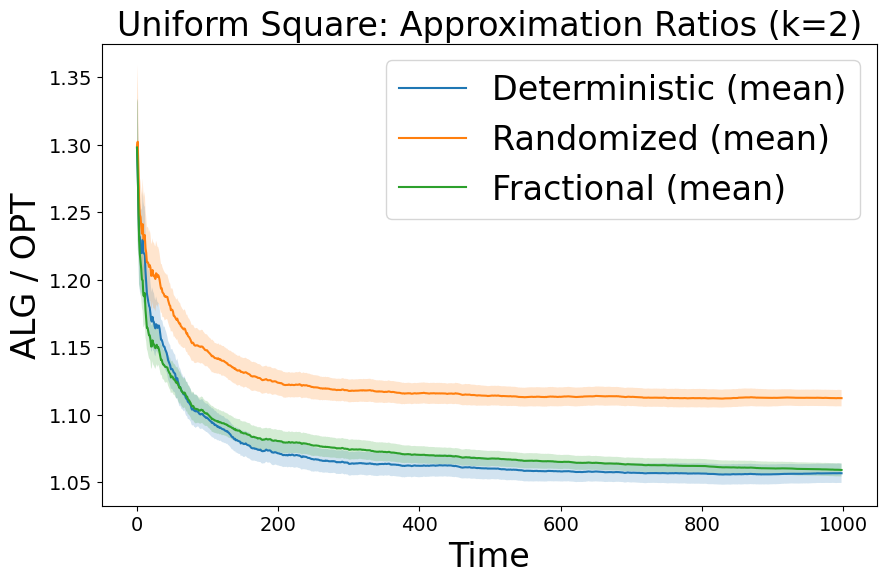

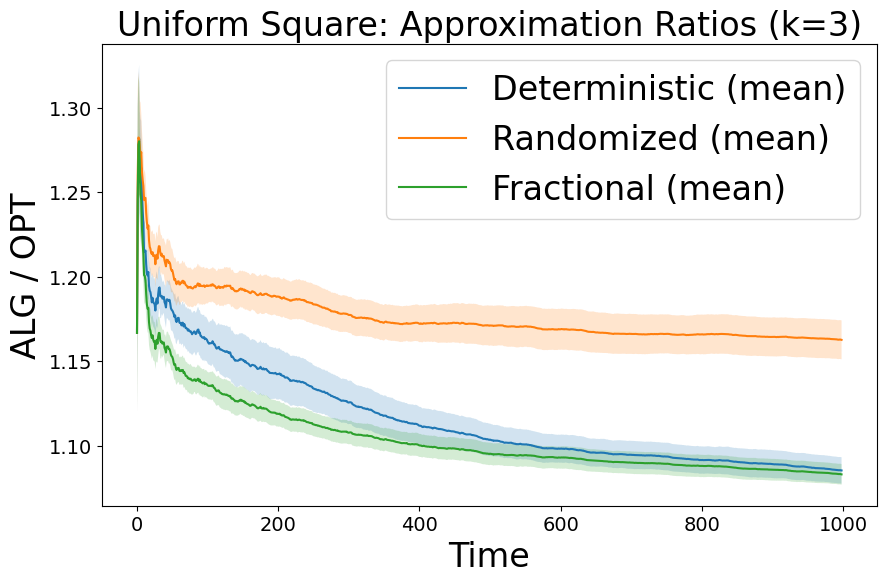

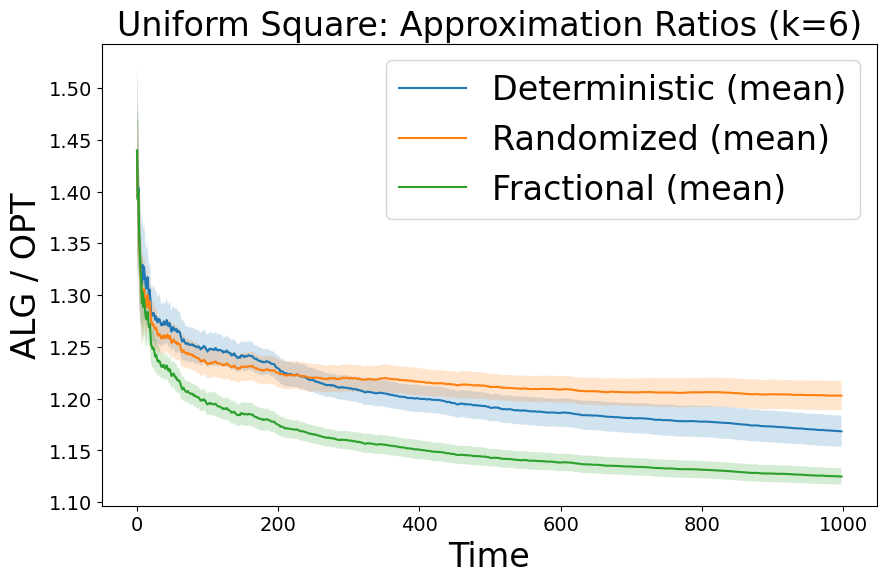

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

seeds = [42, 43, 44, 45, 46]
seeds_main = [i for i in range(42,52)]
for k in [2, 3, 6]:
    # Pre-allocate result containers
    ratio_mean_dict = {}
    ratio_std_dict = {}

    for f in [0, 1, 2]:
        ratio_list = []

        if f == 0:
            # f = 0: Deterministic
            for seed in seeds_main:
                alg_path = f"{base_dir}/uniform_alg_cost_over_time_{k}_{f}_{seed}_{seed}.npy"
                gurobi_path = f"{base_dir}/uniform_gurobi_cost_over_time_{k}_{f}_{seed}_{seed}.npy"

                alg_cost = np.load(alg_path)
                gurobi_cost = np.load(gurobi_path)

                ratio = alg_cost / gurobi_cost
                ratio_list.append(ratio)

        elif f == 2:
            # f = 2: Same as f=0, but using frac_cost instead of alg_cost
            for seed in seeds_main:
                alg_path = f"{base_dir}/uniform_frac_cost_over_time_{k}_{f-2}_{seed}_{seed}.npy"
                gurobi_path = f"{base_dir}/uniform_gurobi_cost_over_time_{k}_{f-2}_{seed}_{seed}.npy"

                alg_cost = np.load(alg_path)
                gurobi_cost = np.load(gurobi_path)

                ratio = alg_cost / gurobi_cost
                ratio_list.append(ratio)

        else:
            # f = 1: Randomized — average over seed_rands for each seed
            for seed in seeds_main:
                seed_rand_costs = []

                for seed_rand in seeds:
                    alg_path = f"{base_dir}/uniform_alg_cost_over_time_{k}_{f}_{seed}_{seed_rand}.npy"
                    alg_cost = np.load(alg_path)
                    seed_rand_costs.append(alg_cost)

                avg_alg_cost = np.mean(np.vstack(seed_rand_costs), axis=0)

                gurobi_path = f"{base_dir}/uniform_gurobi_cost_over_time_{k}_{f}_{seed}_42.npy"
                gurobi_cost = np.load(gurobi_path)

                ratio = avg_alg_cost / gurobi_cost
                ratio_list.append(ratio)

        # Final aggregation over seeds
        ratio_array = np.vstack(ratio_list)  # shape: (5, time_steps)
        ratio_mean_dict[f] = np.mean(ratio_array, axis=0)
        ratio_std_dict[f] = np.std(ratio_array, axis=0)/(10**0.5)

    # Plot f = 0, 1, and 2
    plt.figure(figsize=(10, 6))
    for f in [0, 1, 2]:
        if f == 0:
            label = "Deterministic"
        elif f == 1:
            label = "Randomized"
        else:
            label = "Fractional"

        ratio_mean = ratio_mean_dict[f]
        ratio_std = ratio_std_dict[f]

        plt.plot(ratio_mean, label=f"{label} (mean)")
        plt.fill_between(range(len(ratio_mean)),
                         ratio_mean - ratio_std,
                         ratio_mean + ratio_std,
                         alpha=0.2)

    plt.title(f"Uniform Square: Approximation Ratios (k={k})",fontsize = global_size)
    plt.xticks(fontsize = global_font)
    plt.yticks(fontsize = global_font)
    plt.xlabel("Time",fontsize = global_size)
    plt.ylabel("ALG / OPT",fontsize = global_size)
    plt.legend(fontsize = global_size)
    plt.savefig(f"{base_dir_img}/uniform_ratio_comparison_k{k}.png")
    plt.show()


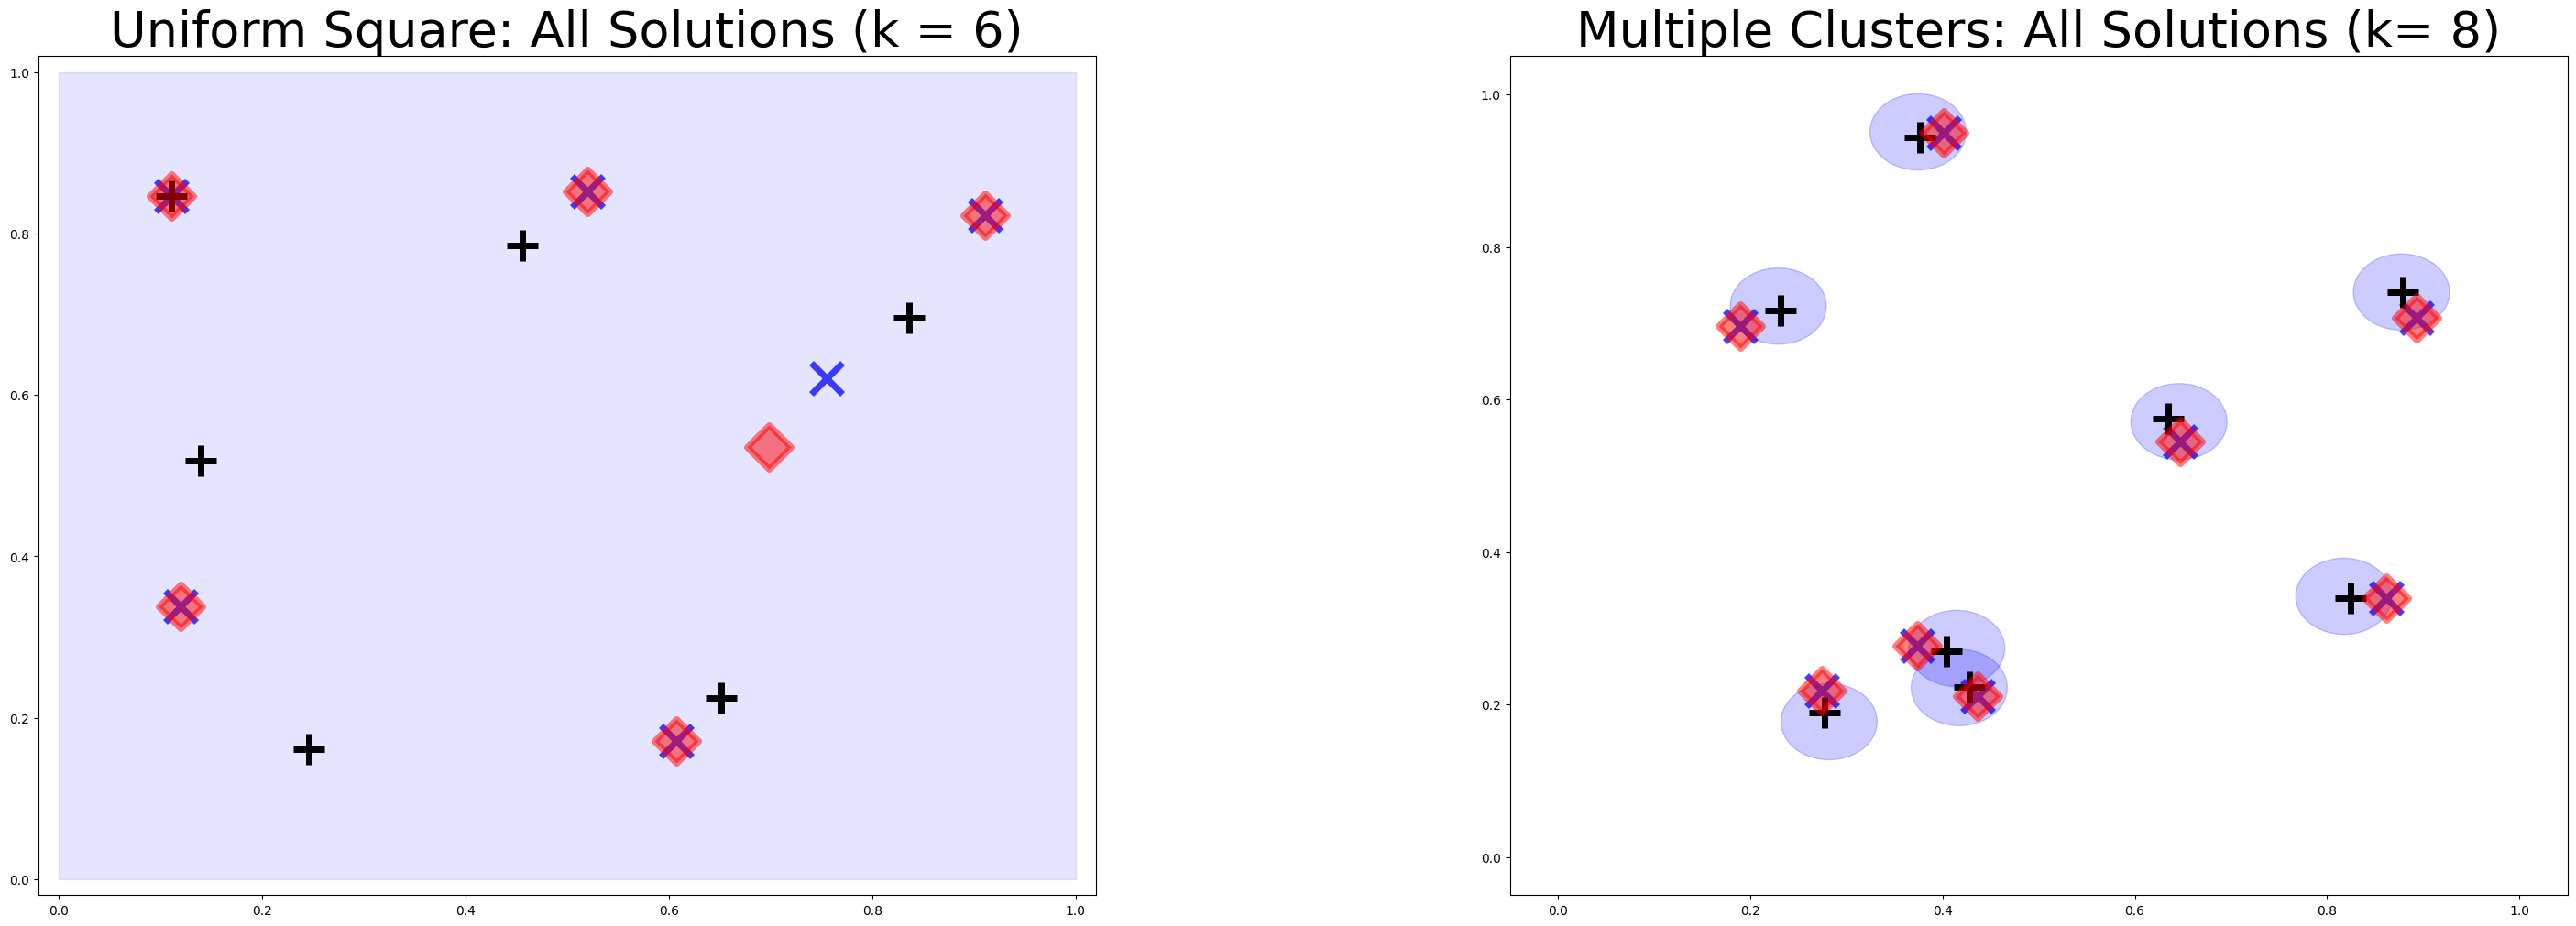

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(28,10), constrained_layout=True,
                         gridspec_kw={'wspace': 0.3})

k = 6
lwidth = 5

# === Left: Uniform case ===
ax = axes[0]
metric_space = np.load(f"{base_dir}/uniform_metric_space_{k}_0_42_42.npy")

# Shade [0,1] square
ax.add_patch(plt.Rectangle((0, 0), 1, 1, color='blue', alpha=0.1))

for f in [0, 1]:
    alg_output = np.load(f"{base_dir}/uniform_alg_output_{k}_{f}_42_42.npy", allow_pickle=True)
    gurobi_opt = np.load(f"{base_dir}/uniform_gurobi_opt_{k}_{f}_42_42.npy", allow_pickle=True)
    text = "Deterministic" if f == 0 else "Randomized"
    centers = metric_space[alg_output]
    if f == 0:
        ax.scatter(centers[:, 0], centers[:, 1], marker='x', color='blue',
                   label=f'ALG ({text})', s=600, alpha=0.75, linewidths= lwidth)
    else:
        ax.scatter(centers[:, 0], centers[:, 1], marker='D', color='red',
                   label=f'ALG ({text})', s=600, alpha=0.5, linewidths = lwidth)
    if f == 0:
        centers = metric_space[gurobi_opt]
        ax.scatter(centers[:, 0], centers[:, 1], color='black', marker='+', label='OPT', s=600, linewidth = lwidth)

ax.set_title("Uniform Square: All Solutions (k = {})".format(k), fontsize = global_size+15)
#ax.set_title(f"Uniform Metric (k={k})", fontsize=global_size-2)
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)

#legend1 = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=global_size+6)
#legend1.get_frame().set_alpha(0.2)
#for text in legend1.get_texts():
#    text.set_color('green')

k=8
# === Right: Varying case ===
ax = axes[1]
metric_space = np.load(f"{base_dir}/varying_metric_space_{k}_0_42_42.npy")
random_points = generate_cluster_centers(400, k, 0.05, 42)

for point in random_points:
    circle = plt.Circle(point, 0.05, color='blue', alpha=0.2)
    ax.add_patch(circle)

for f in [0, 1]:
    text = "Deterministic" if f == 0 else "Randomized"
    alg_output = np.load(f"{base_dir}/varying_alg_output_{k}_{f}_42_42.npy", allow_pickle=True)
    centers = metric_space[alg_output]
    if f == 0:
        ax.scatter(centers[:, 0], centers[:, 1], color='blue', marker='x',
                   label=f'ALG ({text})', s=600, alpha=0.75 ,   linewidths=lwidth  )
    else:
        ax.scatter(centers[:, 0], centers[:, 1], color='red', marker='D',
                   label=f'ALG ({text})', s=600, alpha=0.5, linewidths = lwidth)
    if f == 0:
        gurobi_opt = np.load(f"{base_dir}/varying_gurobi_opt_{k}_{f}_42_42.npy", allow_pickle=True)
        centers = metric_space[gurobi_opt]
        ax.scatter(centers[:, 0], centers[:, 1], color='black', marker='+', label='OPT', s=600, linewidths = lwidth)


ax.set_title("Multiple Clusters: All Solutions (k= {})".format(k), fontsize = global_size+15)
#ax.set_title(f"Clustered Metric (k={k})", fontsize=global_size-2)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

#legend2 = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=global_size+6)
#legend2.get_frame().set_alpha(0.2)
#for text in legend2.get_texts():
#    text.set_color('green')


# === Save output ===
plt.savefig(f"{base_dir_img}/main_scatter_compare_combined.png", bbox_inches='tight')
plt.show()


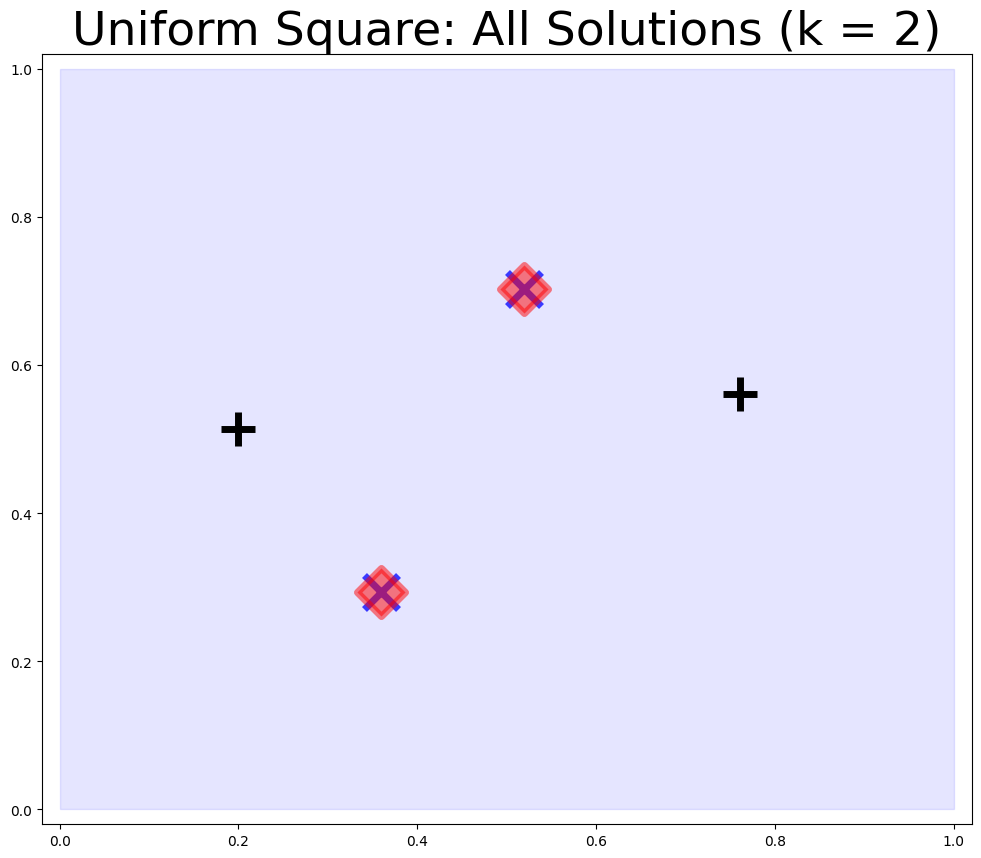

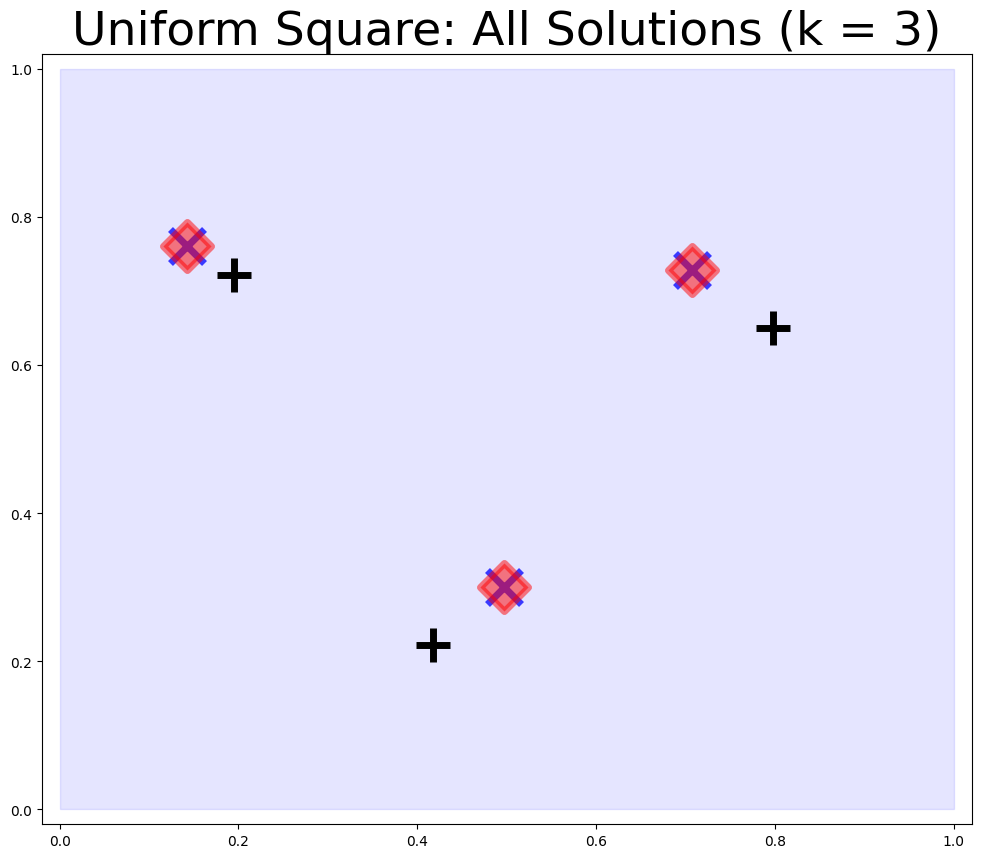

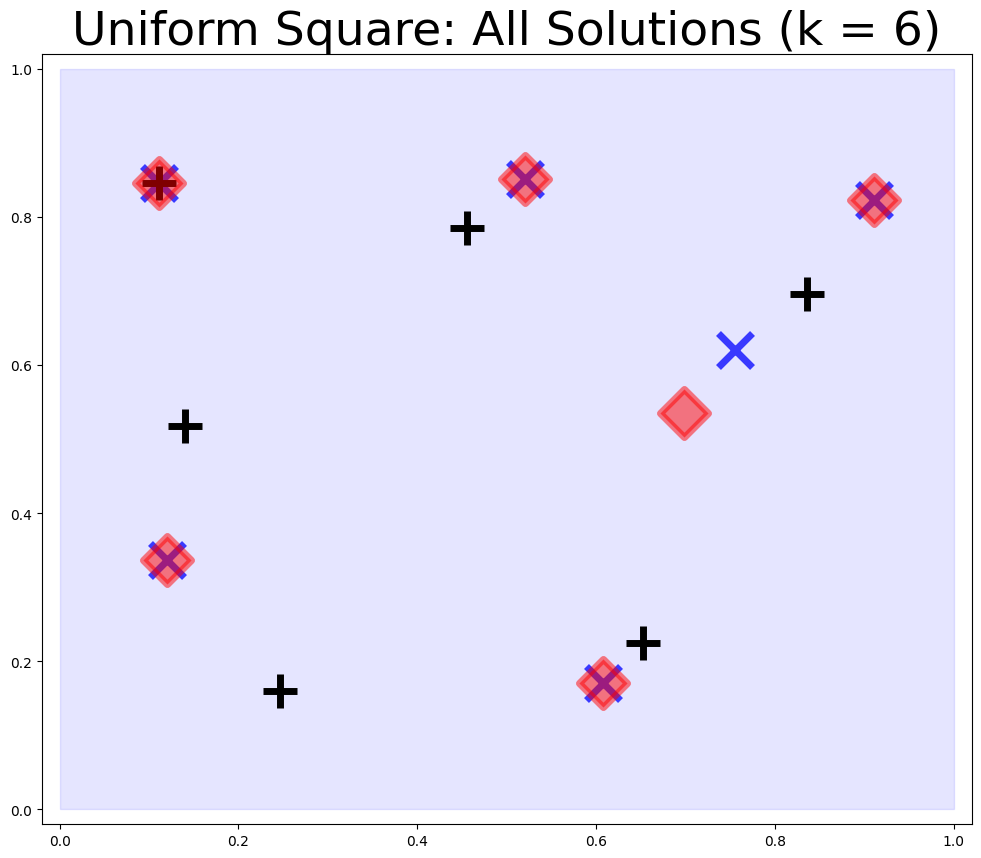

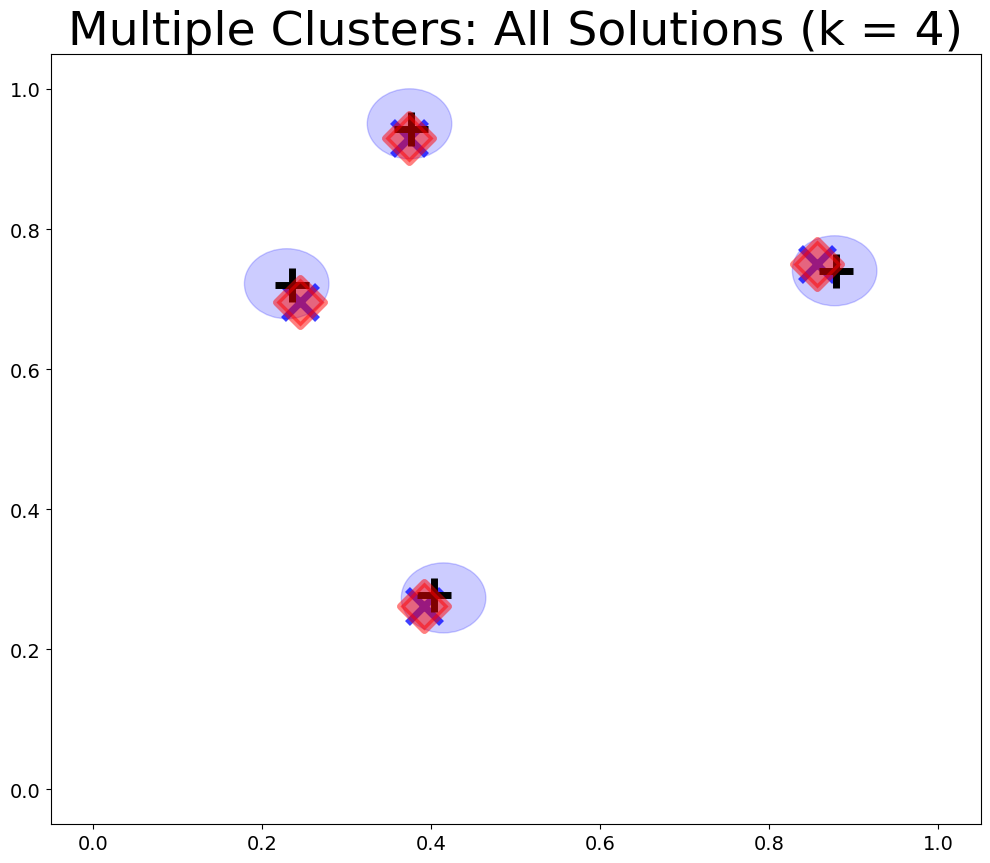

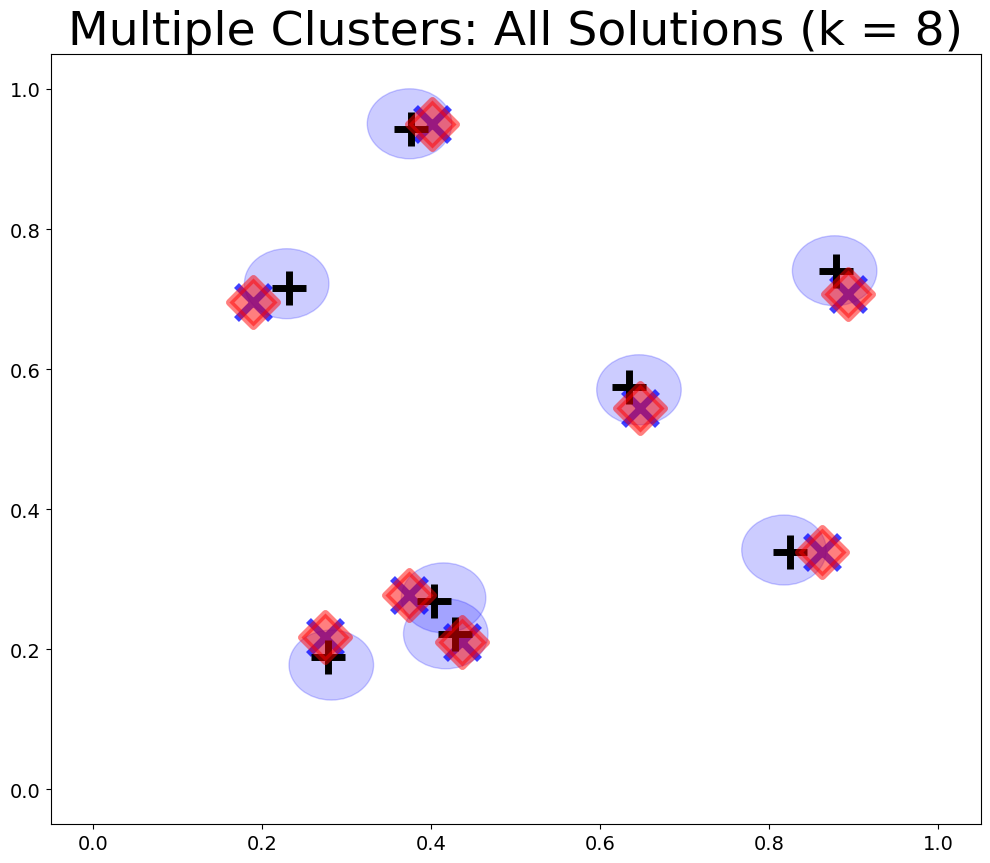

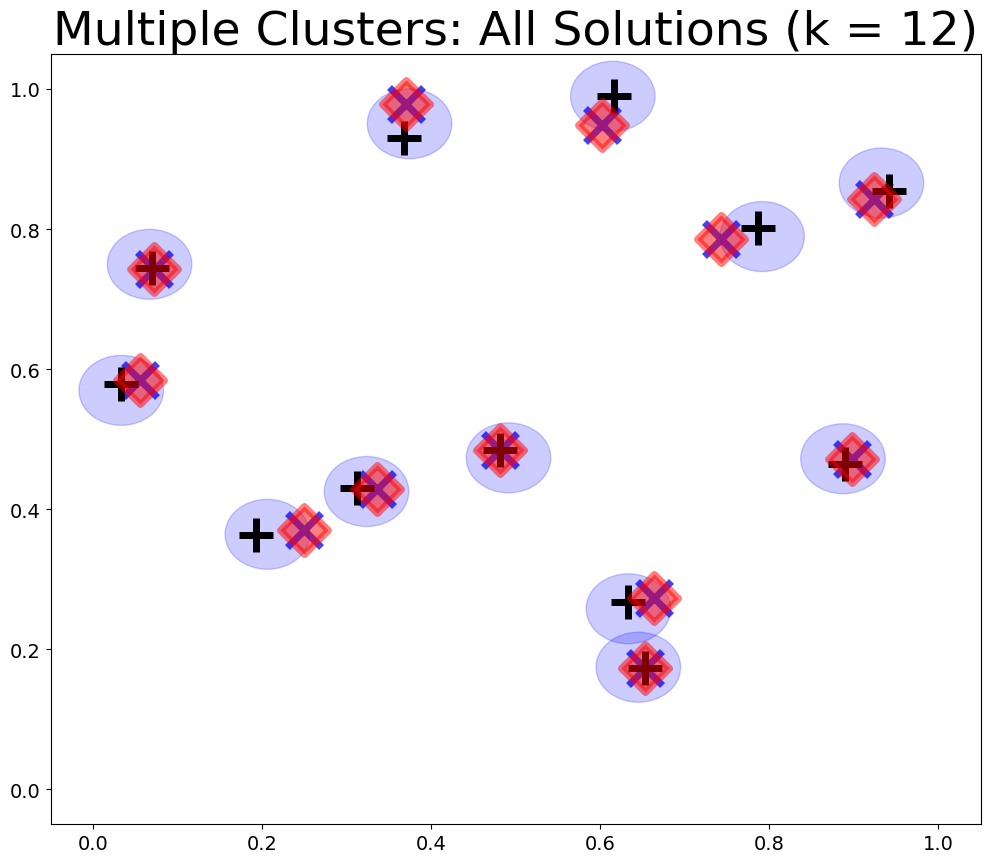

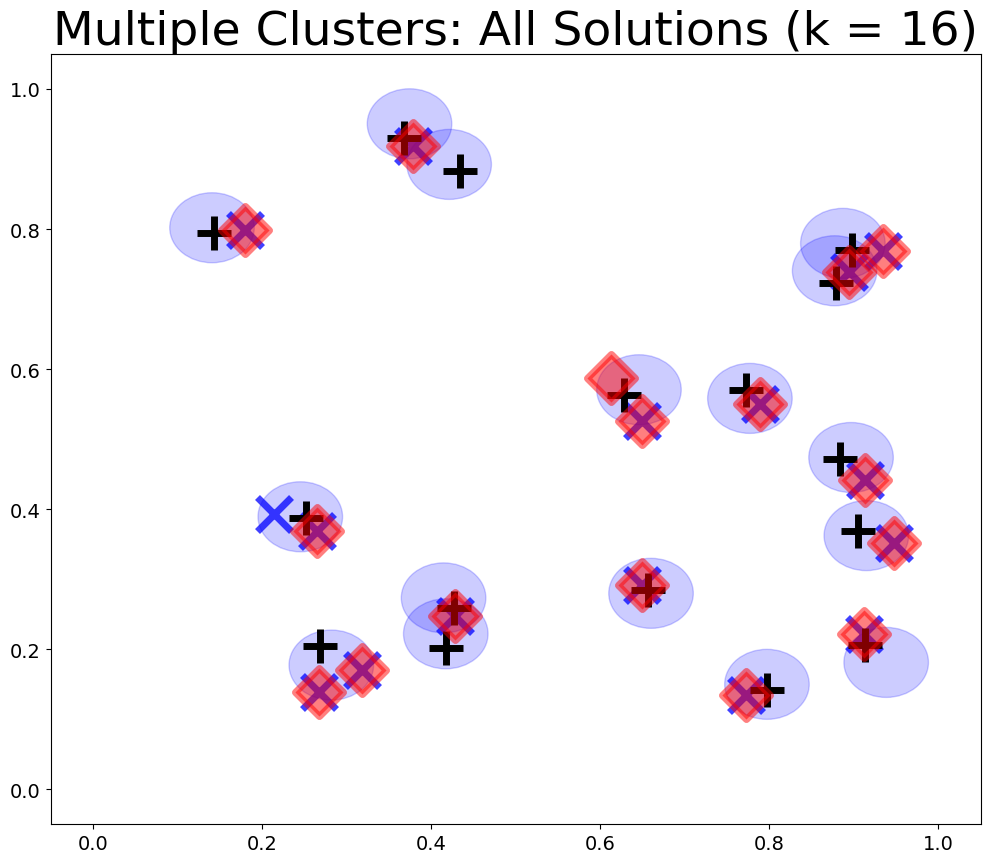

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


lwidth = 5

# === Figure 1: Uniform case ===
for k in [2,3,6]:
  fig1, ax1 = plt.subplots(figsize=(12, 10))
  metric_space = np.load(f"{base_dir}/uniform_metric_space_{k}_0_42_42.npy")

  # Shade [0,1] square
  ax1.add_patch(plt.Rectangle((0, 0), 1, 1, color='blue', alpha=0.1))

  for f in [0, 1]:
      alg_output = np.load(f"{base_dir}/uniform_alg_output_{k}_{f}_42_42.npy", allow_pickle=True)
      gurobi_opt = np.load(f"{base_dir}/uniform_gurobi_opt_{k}_{f}_42_42.npy", allow_pickle=True)
      text = "Deterministic" if f == 0 else "Randomized"
      centers = metric_space[alg_output]
      if f == 0:
          ax1.scatter(centers[:, 0], centers[:, 1], marker='x', color='blue',
                      label=f'ALG ({text})', s=600, alpha=0.75, linewidths=lwidth)
      else:
          ax1.scatter(centers[:, 0], centers[:, 1], marker='D', color='red',
                      label=f'ALG ({text})', s=600, alpha=0.5, linewidths=lwidth)
      if f == 0:
          centers = metric_space[gurobi_opt]
          ax1.scatter(centers[:, 0], centers[:, 1], color='black', marker='+', label='OPT', s=600, linewidth=lwidth)

  ax1.set_title(f"Uniform Square: All Solutions (k = {k})",  fontsize=global_size + 10)
  ax1.set_xlim(-0.02, 1.02)
  ax1.set_ylim(-0.02, 1.02)
  #ax1.legend(fontsize=14)
  plt.savefig(f"{base_dir_img}/uniform_scatter{k}.png", bbox_inches='tight')
  plt.show()


# === Figure 2: Varying case ===
for k in [4,8,12,16]:
  fig2, ax2 = plt.subplots(figsize=(12, 10))
  metric_space = np.load(f"{base_dir}/varying_metric_space_{k}_0_42_42.npy")
  random_points = generate_cluster_centers(400, k, 0.05, 42)

  for point in random_points:
      circle = plt.Circle(point, 0.05, color='blue', alpha=0.2)
      ax2.add_patch(circle)

  for f in [0, 1]:
      text = "Deterministic" if f == 0 else "Randomized"
      alg_output = np.load(f"{base_dir}/varying_alg_output_{k}_{f}_42_42.npy", allow_pickle=True)
      centers = metric_space[alg_output]
      if f == 0:
          ax2.scatter(centers[:, 0], centers[:, 1], color='blue', marker='x',
                      label=f'ALG ({text})', s=600, alpha=0.75, linewidths=lwidth)
      else:
          ax2.scatter(centers[:, 0], centers[:, 1], color='red', marker='D',
                      label=f'ALG ({text})', s=600, alpha=0.5, linewidths=lwidth)
      if f == 0:
          gurobi_opt = np.load(f"{base_dir}/varying_gurobi_opt_{k}_{f}_42_42.npy", allow_pickle=True)
          centers = metric_space[gurobi_opt]
          ax2.scatter(centers[:, 0], centers[:, 1], color='black', marker='+', label='OPT', s=600, linewidths=lwidth)

  ax2.set_title(f"Multiple Clusters: All Solutions (k = {k})", fontsize=global_size + 10)
  ax2.set_xlim(-0.05, 1.05)
  ax2.set_ylim(-0.05, 1.05)
  plt.xticks(fontsize=global_font)
  plt.yticks(fontsize = global_font)
  #ax2.legend(fontsize=14)
  plt.savefig(f"{base_dir_img}/clustered_scatter{k}.png", bbox_inches='tight')
  plt.show()


In [ ]:

# new information

def hypersphere(n,d,k,max_per_round,T,seed,f):
  global metric_space
  global distances
  global distances_sorted
  global dict_used
  global points_used
  global max_grad
  max_grad = 0
  np.random.seed(seed)  # Set seed for reproducibility
  # Generate n-1 points on the unit hypersphere
  metric_space = np.random.randn(n - 1, d)  # Generate random points in d dimensions
  metric_space /= np.linalg.norm(metric_space, axis=1, keepdims=True)  # Normalize to unit length

  # Add the origin as the last point
  metric_space = np.vstack([metric_space, np.zeros(d)])
  selected_points_list = [0]*T
  for i in range(T):
    num_points = max_per_round
    selected_indices = np.random.choice(n-1, num_points, replace=False)  # Pick those many unique points
    selected_points_list[i] = selected_indices

  cost = 0
  frac_cost = 0
  y = 0
  points_used = [0]*n
  dict_used = {}
  alg_output = 0
  selected_points_history = []
  instance_list = []
  alg_cost_over_time = []
  frac_cost_over_time = []
  instance_count = [0]*6
  ground_set = [i for i in range(n)]
  distances = [[dist_metric(y, x) for x in ground_set] for y in ground_set]
  distances_sorted = [0]*n
  for i in range(n):
    temp_arr = [[distances[i][j],j] for j in range(n)]
    temp_arr.sort()
    distances_sorted[i] = temp_arr
  weight_list = []
  total_1 = []
  total_2 = []
  instance_count = [0]*n
  time_start = time.time()
  for t in range(T):
      #print(y)
      if(t%50==0):
        print("time",t,f,k)

      if(t>0):
        total_1.append(sum([y[i][1] for i in range(len(y)) if y[i][0]<=n-2]))
        total_2.append(sum([y[i][1] for i in range(len(y)) if y[i][0]==n-1]))

      num_points = max_per_round
      selected_indices = []
      if(t<100):
        selected_indices = selected_points_list[t]  # Pick those many unique points
      elif(t==100):
        selected_indices = selected_points_list[t]
        selected_indices = np.concatenate([selected_indices, np.array([n-1])])
      else:
        selected_indices = np.random.choice(n-1, num_points, replace=False)
      instance_list.append(selected_indices)
      selected_points_history.append(metric_space[selected_indices])

      weights = [1]*len(selected_indices)

      selected_centers,assignments,local_opt_cost =  gurobi_k_median(ground_set,weights,selected_indices,distances,k)
      gurobi_opt = [ground_set[i] for i in selected_centers]
      weight_list.append(local_opt_cost)


      if(t==0):
        if(f==0):
          y,alg_output = det_online_k_median(selected_indices,y,t,k)
        else:
          y,alg_output = rand_online_k_median(selected_indices,y,t,k)
      else:
        time1 = time.time()
        local_alg_cost = k_median_int_cost(selected_indices,weights,alg_output)
        local_frac_cost = k_median_cost(selected_indices,weights,y)
        cost+= local_alg_cost/local_opt_cost
        frac_cost+= local_frac_cost/local_opt_cost
        alg_cost_over_time.append(cost)
        frac_cost_over_time.append(frac_cost)
        if(f==0):
          y,alg_output = det_online_k_median(selected_indices,y,t,k)
        else:
          y,alg_output = rand_online_k_median(selected_indices,y,t,k)

  gurobi_opt,gurobi_cost_over_time = exp_gurobi_benchmark(instance_list,weight_list,ground_set,distances,k)


  np.save(f"{base_dir}/hypersphere_total_1_{d}_{f}_{seed}.npy", total_1)
  np.save(f"{base_dir}/hypersphere_total_2_{d}_{f}_{seed}.npy", total_2)
  np.save(f"{base_dir}/hypersphere_alg_cost_over_time_{d}_{f}_{seed}.npy", alg_cost_over_time)
  np.save(f"{base_dir}/hypersphere_gurobi_cost_over_time_{d}_{f}_{seed}.npy", gurobi_cost_over_time)
  np.save(f"{base_dir}/hypersphere_frac_cost_over_time_{d}_{f}_{seed}.npy", frac_cost_over_time)



In [ ]:
metric_space = []
points_used = []
dict_used = {}
distances = []
distances_sorted = []
max_grad = 0

for d in [2]:
    for f in [0]:
        for seed in range(47, 52):
            file_path = f"{base_dir}/hypersphere_frac_cost_over_time_{d}_{f}_{seed}.npy"
            if not os.path.exists(file_path):
                hypersphere(400, d, 1, 10, 2000, seed, f)


time 0 0 1
time 50 0 1
time 100 0 1
time 150 0 1
time 200 0 1
time 250 0 1
time 300 0 1
time 350 0 1
time 400 0 1
time 450 0 1
time 500 0 1
time 550 0 1
time 600 0 1
time 650 0 1
time 700 0 1
time 750 0 1
time 800 0 1
time 850 0 1
time 900 0 1
time 950 0 1
time 1000 0 1
time 1050 0 1
time 1100 0 1
time 1150 0 1
time 1200 0 1
time 1250 0 1
time 1300 0 1
time 1350 0 1
time 1400 0 1
time 1450 0 1
time 1500 0 1
time 1550 0 1
time 1600 0 1
time 1650 0 1
time 1700 0 1
time 1750 0 1
time 1800 0 1
time 1850 0 1
time 1900 0 1
time 1950 0 1
time 0 0 1
time 50 0 1
time 100 0 1
time 150 0 1
time 200 0 1
time 250 0 1
time 300 0 1
time 350 0 1
time 400 0 1
time 450 0 1
time 500 0 1
time 550 0 1
time 600 0 1
time 650 0 1
time 700 0 1
time 750 0 1
time 800 0 1
time 850 0 1
time 900 0 1
time 950 0 1
time 1000 0 1
time 1050 0 1
time 1100 0 1
time 1150 0 1
time 1200 0 1
time 1250 0 1
time 1300 0 1
time 1350 0 1
time 1400 0 1
time 1450 0 1
time 1500 0 1
time 1550 0 1
time 1600 0 1
time 1650 0 1
time 1700 

Mounted at /content/drive


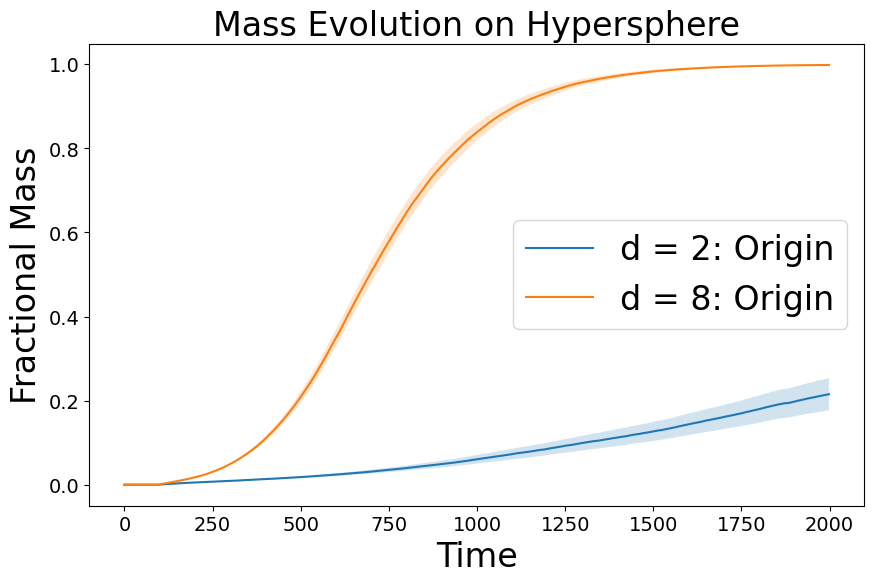

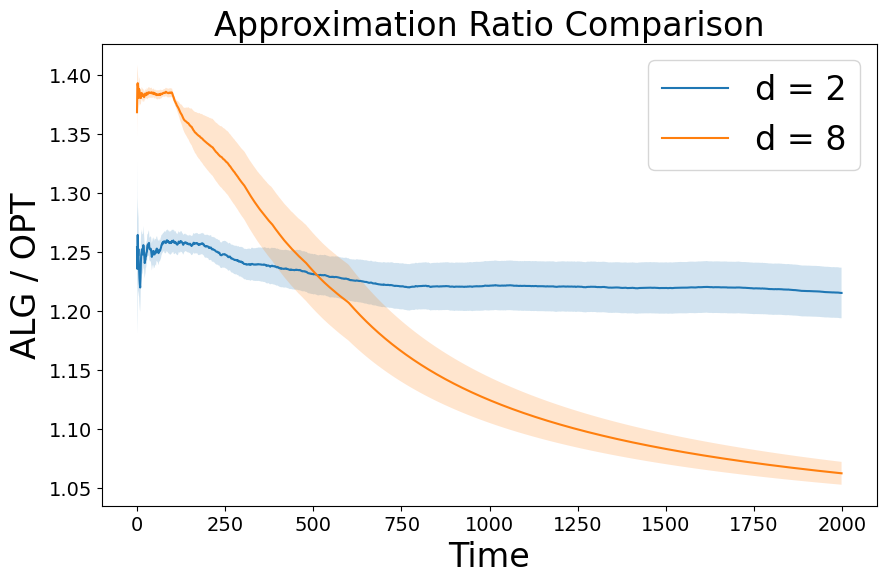

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

seeds = [42, 43, 44, 45, 46,47,48,49,50,51]
dims = [2, 8]

# Store computed results
mass_means = {}
mass_stds = {}
ratio_means = {}
ratio_stds = {}

for d in dims:
    total_1_list = []
    total_2_list = []
    ratio_list = []

    for seed in seeds:
        total_1 = np.load(f"{base_dir}/hypersphere_total_1_{d}_0_{seed}.npy")
        total_2 = np.load(f"{base_dir}/hypersphere_total_2_{d}_0_{seed}.npy")
        alg_cost = np.load(f"{base_dir}/hypersphere_alg_cost_over_time_{d}_0_{seed}.npy")
        gurobi_cost = np.load(f"{base_dir}/hypersphere_gurobi_cost_over_time_{d}_0_{seed}.npy")

        total_1_list.append(total_1)
        total_2_list.append(total_2)
        ratio_list.append(alg_cost / gurobi_cost)

    total_1_array = np.vstack(total_1_list)
    total_2_array = np.vstack(total_2_list)
    ratio_array = np.vstack(ratio_list)

    mass_means[d] = {
        'total_1': np.mean(total_1_array, axis=0),
        'total_2': np.mean(total_2_array, axis=0)
    }
    mass_stds[d] = {
        'total_1': np.std(total_1_array, axis=0)/10**0.5,
        'total_2': np.std(total_2_array, axis=0)/10**0.5
    }
    ratio_means[d] = np.mean(ratio_array, axis=0)
    ratio_stds[d] = np.std(ratio_array, axis=0)/10**0.5

# Plot 1: Mass evolution for d=2 and d=8
plt.figure(figsize=(10, 6))
for d in dims:
    x = range(len(mass_means[d]['total_1']))

    #plt.plot(mass_means[d]['total_1'], label=f"d = {d}: Unit Hypersphere")
    #plt.fill_between(x,
    #                 mass_means[d]['total_1'] - mass_stds[d]['total_1'],
    #                 mass_means[d]['total_1'] + mass_stds[d]['total_1'],
    #                 alpha=0.2)

    plt.plot(mass_means[d]['total_2'], label=f"d = {d}: Origin")
    plt.fill_between(x,
                     mass_means[d]['total_2'] - mass_stds[d]['total_2'],
                     mass_means[d]['total_2'] + mass_stds[d]['total_2'],
                     alpha=0.2)

plt.title("Mass Evolution on Hypersphere",fontsize = global_size)
plt.xticks(fontsize = global_font)
plt.yticks(fontsize = global_font)
plt.xlabel("Time",fontsize = global_size)
plt.ylabel("Fractional Mass",fontsize = global_size)
plt.legend(fontsize = global_size)
plt.savefig(f"{base_dir_img}/hypersphere_frac_combined.png")
plt.show()

# Plot 2: Approximation ratios
plt.figure(figsize=(10, 6))
for d in dims:
    x = range(len(ratio_means[d]))

    plt.plot(ratio_means[d], label=f"d = {d}")
    plt.fill_between(x,
                     ratio_means[d] - ratio_stds[d],
                     ratio_means[d] + ratio_stds[d],
                     alpha=0.2)

plt.title("Approximation Ratio Comparison",fontsize = global_size)
plt.xticks(fontsize = global_font)
plt.yticks(fontsize = global_font)
plt.xlabel("Time",fontsize = global_size)
plt.ylabel("ALG / OPT",fontsize = global_size)
plt.legend(fontsize = global_size)
plt.savefig(f"{base_dir_img}/hypersphere_ratio_combined.png")
plt.show()


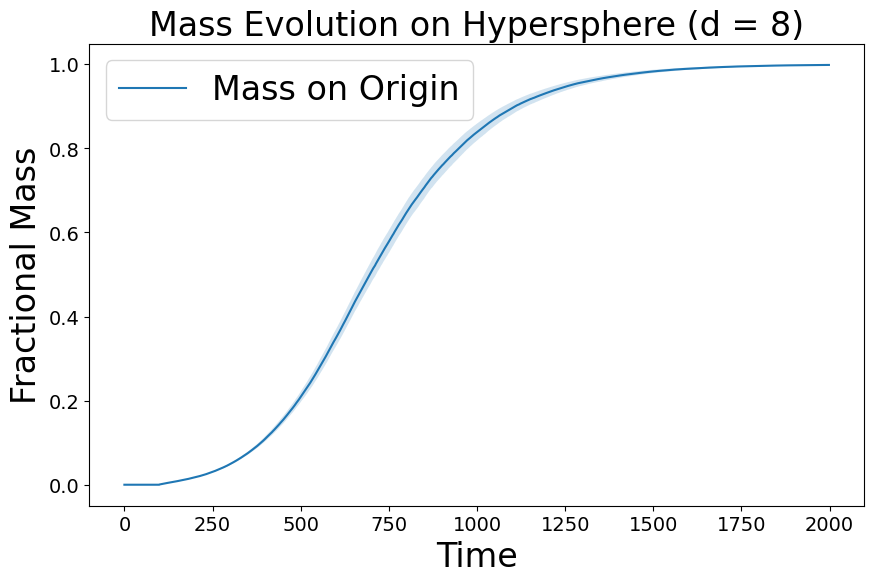

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

seeds = [i for i in range(42,52)]
dims = [8]

# Store computed results
mass_means = {}
mass_stds = {}
ratio_means = {}
ratio_stds = {}

for d in dims:
    total_1_list = []
    total_2_list = []
    ratio_list = []

    for seed in seeds:
        total_1 = np.load(f"{base_dir}/hypersphere_total_1_{d}_0_{seed}.npy")
        total_2 = np.load(f"{base_dir}/hypersphere_total_2_{d}_0_{seed}.npy")
        alg_cost = np.load(f"{base_dir}/hypersphere_alg_cost_over_time_{d}_0_{seed}.npy")
        gurobi_cost = np.load(f"{base_dir}/hypersphere_gurobi_cost_over_time_{d}_0_{seed}.npy")

        total_1_list.append(total_1)
        total_2_list.append(total_2)
        ratio_list.append(alg_cost / gurobi_cost)

    total_1_array = np.vstack(total_1_list)
    total_2_array = np.vstack(total_2_list)
    ratio_array = np.vstack(ratio_list)

    mass_means[d] = {
        'total_1': np.mean(total_1_array, axis=0),
        'total_2': np.mean(total_2_array, axis=0)
    }
    mass_stds[d] = {
        'total_1': np.std(total_1_array, axis=0)/10**0.5,
        'total_2': np.std(total_2_array, axis=0)/10**0.5
    }
    ratio_means[d] = np.mean(ratio_array, axis=0)
    ratio_stds[d] = np.std(ratio_array, axis=0)/10**0.5

# Plot 1: Mass evolution for d=2 and d=8
plt.figure(figsize=(10, 6))
for d in dims:
    x = range(len(mass_means[d]['total_1']))

    #plt.plot(mass_means[d]['total_1'], label=f"d = {d}: Unit Hypersphere")
    #plt.fill_between(x,
    #                 mass_means[d]['total_1'] - mass_stds[d]['total_1'],
    #                 mass_means[d]['total_1'] + mass_stds[d]['total_1'],
    #                 alpha=0.2)

    plt.plot(mass_means[d]['total_2'], label=f"Mass on Origin")
    plt.fill_between(x,
                     mass_means[d]['total_2'] - mass_stds[d]['total_2'],
                     mass_means[d]['total_2'] + mass_stds[d]['total_2'],
                     alpha=0.2)

plt.title("Mass Evolution on Hypersphere (d = {})".format(d),fontsize =global_size )
plt.xlabel("Time",fontsize = global_size)
plt.xticks(fontsize = global_font)
plt.yticks(fontsize = global_font)
plt.ylabel("Fractional Mass", fontsize = global_size)
plt.legend(fontsize = global_size)

plt.savefig(f"{base_dir_img}/hypersphere_frac.png")
plt.show()



In [ ]:
##  Varying Clusters


def generate_cluster_centers(n, k, radius,seed):
  global metric_space
  """Generates a metric space with k clusters (points in a ball)."""
  cluster_size = n // k - 1
  cluster_points_list = []  # Collect all cluster points
  center_list = []
  np.random.seed(seed)
  for _ in range(k):
    center = np.random.rand(2)
    center_list.append(center)
    cluster_points = []

    while len(cluster_points) < cluster_size:
      # Generate a candidate point
      point = center + (np.random.rand(2) - 0.5) * 2 * radius

      # Check if it's within the radius
      if np.linalg.norm(point - center) <= radius:
        cluster_points.append(point)

    cluster_points_list.extend(cluster_points)  # Add to the overall list

  metric_space = np.array(cluster_points_list)  # Convert to NumPy array

  return center_list # Return the NumPy array


def generate_clustered_metric_space(n, k, radius):
  global metric_space
  """Generates a metric space with k clusters (points in a ball)."""
  cluster_size = n // k - 1
  cluster_points_list = []  # Collect all cluster points

  for _ in range(k):
    center = np.random.rand(2)
    cluster_points = []

    while len(cluster_points) < cluster_size:
      # Generate a candidate point
      point = center + (np.random.rand(2) - 0.5) * 2 * radius

      # Check if it's within the radius
      if np.linalg.norm(point - center) <= radius:
        cluster_points.append(point)

    cluster_points_list.extend(cluster_points)  # Add to the overall list

  metric_space = np.array(cluster_points_list)  # Convert to NumPy array

  return metric_space # Return the NumPy array

def varying_clusters(n,k,max_per_round,T,seed,seed_rands):
  global distances
  global distances_sorted
  global metric_space
  global points_used
  global dict_used
  global max_grad
  max_grad = 0
  radius = 0.05
  np.random.seed(seed)
  generate_clustered_metric_space(n, k, radius)
  n = len(metric_space)
  #----------------------
  selected_points_list = [0]*T
  for i in range(T):
    num_points = max_per_round
    selected_indices = np.random.choice(n, num_points, replace=False)  # Pick those many unique points
    selected_points_list[i] = selected_indices

  selected_points_history = []
  cost = 0
  costs = [0]*(len(seed_rands))
  frac_cost = 0
  y = 0
  points_used = [0]*n
  dict_used = {}
  alg_output = 0
  alg_outputs = 0
  instance_list = []
  alg_cost_over_time = []
  alg_costs_over_time = [0]*len(seed_rands)
  alg_output_over_time = []
  alg_outputs_over_time =  [0]*len(seed_rands)
  for i in range(len(seed_rands)):
    alg_costs_over_time[i],alg_outputs_over_time[i] = [],[]

  y_output_over_time = []
  frac_cost_over_time = []
  instance_count = [0]*400
  ground_set = [i for i in range(n)]
  distances = [[dist_metric(y, x) for x in ground_set] for y in ground_set]
  distances_sorted = [0]*n
  for i in range(n):
    temp_arr = [[distances[i][j],j] for j in range(n)]
    temp_arr.sort()
    distances_sorted[i] = temp_arr
  weight_list = []

  for t in range(T):
      if(t%50 ==0):
        print("time",t,k)
      num_points = max_per_round
      selected_indices = selected_points_list[t] # Pick those many unique points
      #if(t>10):
      #  selected_indices = [2*i+t%2 for i in range(10)]
      instance_list.append(selected_indices)
      selected_points_history.append(metric_space[selected_indices])
      weights = [1]*len(selected_indices)
      selected_centers,assignments,local_opt_cost =  gurobi_k_median(ground_set,weights,selected_indices,distances,k)
      gurobi_opt = [ground_set[i] for i in selected_centers]
      weight_list.append(local_opt_cost)

      if(t==0):
          y,alg_output = det_online_k_median(selected_indices,y,t,k)
          alg_outputs = [alg_output]*len(seed_rands)
      else:
            local_alg_cost = k_median_int_cost(selected_indices,weights,alg_output)
            local_frac_cost =   k_median_cost(selected_indices,weights,y)
            cost+= local_alg_cost/local_opt_cost
            frac_cost+= local_frac_cost/local_opt_cost

            alg_cost_over_time.append(cost)
            frac_cost_over_time.append(frac_cost)
            y_output_over_time.append(y)
            alg_output_over_time.append(alg_output)

            for i in range(len(seed_rands)):
                local_alg_cost = k_median_int_cost(selected_indices,weights,alg_outputs[i])
                costs[i]+= local_alg_cost/local_opt_cost
                alg_costs_over_time[i].append(costs[i])
                alg_outputs_over_time[i].append(alg_outputs[i])

            y,alg_output = det_online_k_median(selected_indices,y,t,k)
            for i in range(len(seed_rands)):
                np.random.seed(seed_rands[i])
                alg_outputs[i] = rand_rounding(y,k)

  gurobi_opt,gurobi_cost_over_time = exp_gurobi_benchmark(instance_list,weight_list,ground_set,distances,k)
  # Save files into the base directory with the "varying_" prefix
  np.save(f"{base_dir}/varying_selected_points_history_{k}_0_{seed}_{seed}.npy", selected_points_history)
  np.save(f"{base_dir}/varying_alg_output_{k}_0_{seed}_{seed}.npy", alg_output)
  np.save(f"{base_dir}/varying_gurobi_opt_{k}_0_{seed}_{seed}.npy", gurobi_opt)
  np.save(f"{base_dir}/varying_metric_space_{k}_0_{seed}_{seed}.npy", metric_space)
  np.save(f"{base_dir}/varying_alg_output_over_time_{k}_0_{seed}_{seed}.npy", alg_output_over_time)
  np.save(f"{base_dir}/varying_y_output_over_time_{k}_0_{seed}_{seed}.npy", np.array(y_output_over_time, dtype=object), allow_pickle=True)
  np.save(f"{base_dir}/varying_alg_cost_over_time_{k}_0_{seed}_{seed}.npy", alg_cost_over_time)
  np.save(f"{base_dir}/varying_gurobi_cost_over_time_{k}_0_{seed}_{seed}.npy", gurobi_cost_over_time)
  np.save(f"{base_dir}/varying_frac_cost_over_time_{k}_0_{seed}_{seed}.npy",frac_cost_over_time)
  cnt = 0
  for seed_rand in seed_rands:
    # Save files into the base directory with the "varying_" prefix
        np.save(f"{base_dir}/varying_selected_points_history_{k}_1_{seed}_{seed_rand}.npy", selected_points_history)
        np.save(f"{base_dir}/varying_alg_output_{k}_1_{seed}_{seed_rand}.npy", alg_outputs[cnt])
        np.save(f"{base_dir}/varying_gurobi_opt_{k}_1_{seed}_{seed_rand}.npy", gurobi_opt)
        np.save(f"{base_dir}/varying_metric_space_{k}_1_{seed}_{seed_rand}.npy", metric_space)
        np.save(f"{base_dir}/varying_alg_output_over_time_{k}_1_{seed}_{seed_rand}.npy", alg_outputs_over_time[cnt])
        np.save(f"{base_dir}/varying_y_output_over_time_{k}_1_{seed}_{seed_rand}.npy", np.array(y_output_over_time, dtype=object), allow_pickle=True)
        np.save(f"{base_dir}/varying_alg_cost_over_time_{k}_1_{seed}_{seed_rand}.npy", alg_costs_over_time[cnt])
        np.save(f"{base_dir}/varying_gurobi_cost_over_time_{k}_1_{seed}_{seed_rand}.npy", gurobi_cost_over_time)
        np.save(f"{base_dir}/varying_frac_cost_over_time_{k}_1_{seed}_{seed_rand}.npy",frac_cost_over_time)
        cnt+=1




In [ ]:
##  Varying Clusters


def generate_cluster_centers(n, k, radius,seed):
  global metric_space
  """Generates a metric space with k clusters (points in a ball)."""
  cluster_size = n // k - 1
  cluster_points_list = []  # Collect all cluster points
  center_list = []
  np.random.seed(seed)
  for _ in range(k):
    center = np.random.rand(2)
    center_list.append(center)
    cluster_points = []

    while len(cluster_points) < cluster_size:
      # Generate a candidate point
      point = center + (np.random.rand(2) - 0.5) * 2 * radius

      # Check if it's within the radius
      if np.linalg.norm(point - center) <= radius:
        cluster_points.append(point)

    cluster_points_list.extend(cluster_points)  # Add to the overall list

  metric_space = np.array(cluster_points_list)  # Convert to NumPy array

  return center_list # Return the NumPy array


def generate_clustered_metric_space(n, k, radius):
  global metric_space
  """Generates a metric space with k clusters (points in a ball)."""
  cluster_size = n // k - 1
  cluster_points_list = []  # Collect all cluster points

  for _ in range(k):
    center = np.random.rand(2)
    cluster_points = []

    while len(cluster_points) < cluster_size:
      # Generate a candidate point
      point = center + (np.random.rand(2) - 0.5) * 2 * radius

      # Check if it's within the radius
      if np.linalg.norm(point - center) <= radius:
        cluster_points.append(point)

    cluster_points_list.extend(cluster_points)  # Add to the overall list

  metric_space = np.array(cluster_points_list)  # Convert to NumPy array

  return metric_space # Return the NumPy array

def varying_clusters(n,k,max_per_round,T,seed,seed_rands):
  global distances
  global distances_sorted
  global metric_space
  global points_used
  global dict_used
  global max_grad
  max_grad = 0
  radius = 0.05
  np.random.seed(seed)
  generate_clustered_metric_space(n, k, radius)
  n = len(metric_space)
  #----------------------
  selected_points_list = [0]*T
  for i in range(T):
    num_points = max_per_round
    selected_indices = np.random.choice(n, num_points, replace=False)  # Pick those many unique points
    selected_points_list[i] = selected_indices

  selected_points_history = []
  cost = 0
  costs = [0]*(len(seed_rands))
  frac_cost = 0
  y = 0
  points_used = [0]*n
  dict_used = {}
  alg_output = 0
  alg_outputs = 0
  instance_list = []
  alg_cost_over_time = []
  alg_costs_over_time = [0]*len(seed_rands)
  alg_output_over_time = []
  alg_outputs_over_time =  [0]*len(seed_rands)
  for i in range(len(seed_rands)):
    alg_costs_over_time[i],alg_outputs_over_time[i] = [],[]

  y_output_over_time = []
  frac_cost_over_time = []
  instance_count = [0]*400
  ground_set = [i for i in range(n)]
  distances = [[dist_metric(y, x) for x in ground_set] for y in ground_set]
  distances_sorted = [0]*n
  for i in range(n):
    temp_arr = [[distances[i][j],j] for j in range(n)]
    temp_arr.sort()
    distances_sorted[i] = temp_arr
  weight_list = []

  for t in range(T):
      if(t%50 ==0):
        print("time",t,k)
      num_points = max_per_round
      selected_indices = selected_points_list[t] # Pick those many unique points
      #if(t>10):
      #  selected_indices = [2*i+t%2 for i in range(10)]
      instance_list.append(selected_indices)
      selected_points_history.append(metric_space[selected_indices])
      weights = [1]*len(selected_indices)
      selected_centers,assignments,local_opt_cost =  gurobi_k_median(ground_set,weights,selected_indices,distances,k)
      gurobi_opt = [ground_set[i] for i in selected_centers]
      weight_list.append(local_opt_cost)

      if(t==0):
          y,alg_output = det_online_k_median(selected_indices,y,t,k)
          alg_outputs = [alg_output]*len(seed_rands)
      else:
            local_alg_cost = k_median_int_cost(selected_indices,weights,alg_output)
            local_frac_cost =   k_median_cost(selected_indices,weights,y)
            cost+= local_alg_cost/local_opt_cost
            frac_cost+= local_frac_cost/local_opt_cost

            alg_cost_over_time.append(cost)
            frac_cost_over_time.append(frac_cost)
            y_output_over_time.append(y)
            alg_output_over_time.append(alg_output)

            for i in range(len(seed_rands)):
                local_alg_cost = k_median_int_cost(selected_indices,weights,alg_outputs[i])
                costs[i]+= local_alg_cost/local_opt_cost
                alg_costs_over_time[i].append(costs[i])
                alg_outputs_over_time[i].append(alg_outputs[i])

            y,alg_output = det_online_k_median(selected_indices,y,t,k)
            for i in range(len(seed_rands)):
                np.random.seed(seed_rands[i])
                alg_outputs[i] = rand_rounding(y,k)

  gurobi_opt,gurobi_cost_over_time = exp_gurobi_benchmark(instance_list,weight_list,ground_set,distances,k)
  # Save files into the base directory with the "varying_" prefix
  np.save(f"{base_dir}/varying_selected_points_history_{k}_0_{seed}_{seed}.npy", selected_points_history)
  np.save(f"{base_dir}/varying_alg_output_{k}_0_{seed}_{seed}.npy", alg_output)
  np.save(f"{base_dir}/varying_gurobi_opt_{k}_0_{seed}_{seed}.npy", gurobi_opt)
  np.save(f"{base_dir}/varying_metric_space_{k}_0_{seed}_{seed}.npy", metric_space)
  np.save(f"{base_dir}/varying_alg_output_over_time_{k}_0_{seed}_{seed}.npy", alg_output_over_time)
  np.save(f"{base_dir}/varying_y_output_over_time_{k}_0_{seed}_{seed}.npy", np.array(y_output_over_time, dtype=object), allow_pickle=True)
  np.save(f"{base_dir}/varying_alg_cost_over_time_{k}_0_{seed}_{seed}.npy", alg_cost_over_time)
  np.save(f"{base_dir}/varying_gurobi_cost_over_time_{k}_0_{seed}_{seed}.npy", gurobi_cost_over_time)
  np.save(f"{base_dir}/varying_frac_cost_over_time_{k}_0_{seed}_{seed}.npy",frac_cost_over_time)
  cnt = 0
  for seed_rand in seed_rands:
    # Save files into the base directory with the "varying_" prefix
        np.save(f"{base_dir}/varying_selected_points_history_{k}_1_{seed}_{seed_rand}.npy", selected_points_history)
        np.save(f"{base_dir}/varying_alg_output_{k}_1_{seed}_{seed_rand}.npy", alg_outputs[cnt])
        np.save(f"{base_dir}/varying_gurobi_opt_{k}_1_{seed}_{seed_rand}.npy", gurobi_opt)
        np.save(f"{base_dir}/varying_metric_space_{k}_1_{seed}_{seed_rand}.npy", metric_space)
        np.save(f"{base_dir}/varying_alg_output_over_time_{k}_1_{seed}_{seed_rand}.npy", alg_outputs_over_time[cnt])
        np.save(f"{base_dir}/varying_y_output_over_time_{k}_1_{seed}_{seed_rand}.npy", np.array(y_output_over_time, dtype=object), allow_pickle=True)
        np.save(f"{base_dir}/varying_alg_cost_over_time_{k}_1_{seed}_{seed_rand}.npy", alg_costs_over_time[cnt])
        np.save(f"{base_dir}/varying_gurobi_cost_over_time_{k}_1_{seed}_{seed_rand}.npy", gurobi_cost_over_time)
        np.save(f"{base_dir}/varying_frac_cost_over_time_{k}_1_{seed}_{seed_rand}.npy",frac_cost_over_time)
        cnt+=1




In [ ]:
shuffle_seed = 120
np.random.seed(shuffle_seed)

# Clear or initialize required structures
metric_space = []
points_used = []
dict_used = {}
distances = []
distances_sorted = []
seed_rands= [i for i in range(42,47)]
# Generate and shuffle combinations
all_combinations = [
    (k, seed)
    for k in [4,8,12,16]
    for seed in range(47,52)
]
np.random.shuffle(all_combinations)

# Iterate through shuffled combinations
for k, seed in all_combinations:
    flag = 0

    file_path = f"{base_dir}/varying_frac_cost_over_time_{k}_0_{seed}_{seed}.npy"
    if os.path.exists(file_path):
            flag = 1
            continue


    print("Progress", k, seed)
    if flag == 0:
            varying_clusters(400, k, 20, 1000, seed, seed_rands)


Progress 8 51
time 0 8
time 50 8
time 100 8
time 150 8
time 200 8
time 250 8
time 300 8
time 350 8
time 400 8
time 450 8
time 500 8
time 550 8
time 600 8
time 650 8
time 700 8
time 750 8
time 800 8
time 850 8
time 900 8
time 950 8
Progress 8 47
time 0 8
time 50 8
time 100 8
time 150 8
time 200 8
time 250 8
time 300 8
time 350 8
time 400 8
time 450 8
time 500 8
time 550 8
time 600 8
time 650 8
time 700 8
time 750 8
time 800 8
time 850 8
time 900 8
time 950 8
Progress 12 48
time 0 12


KeyboardInterrupt: 

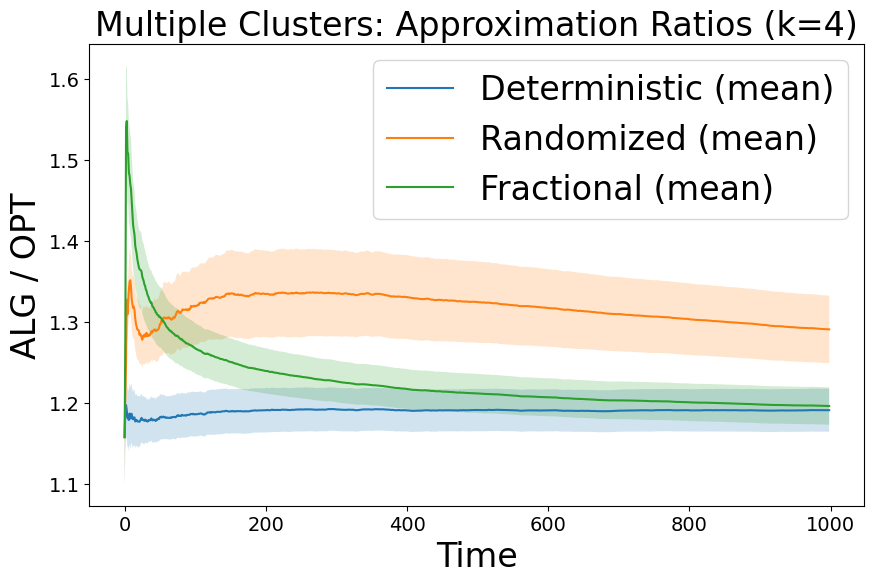

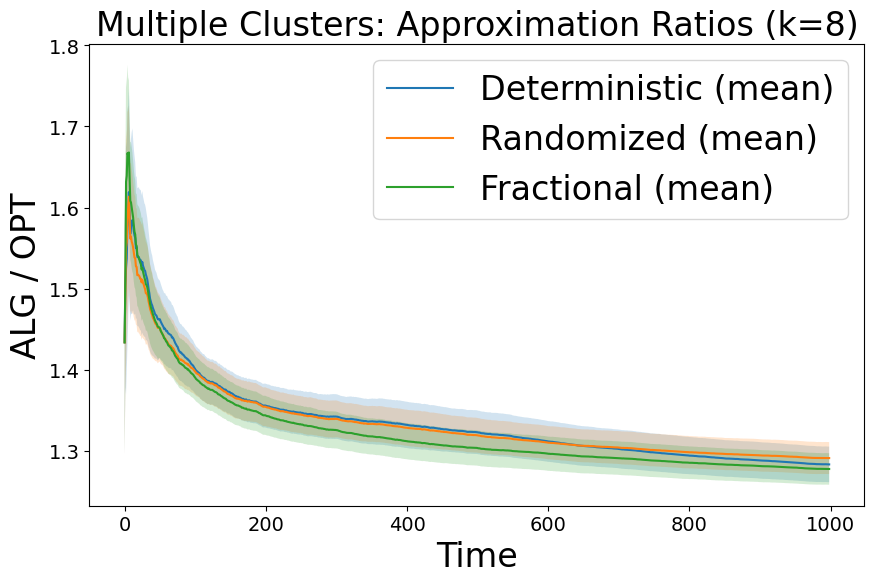

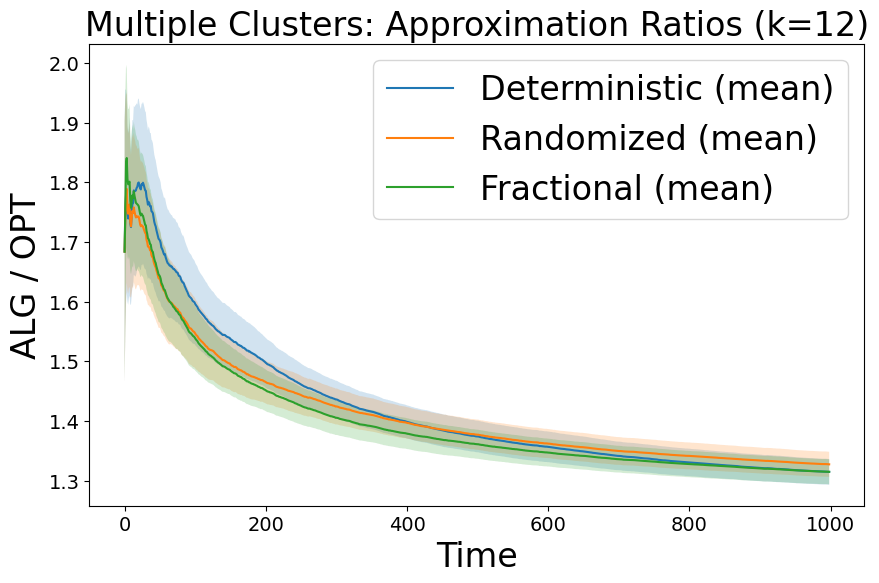

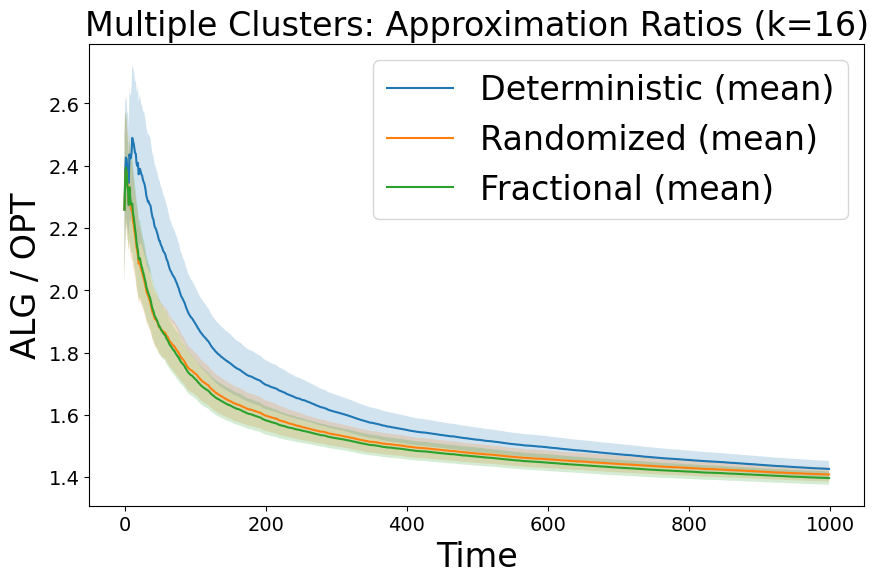

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
seeds_main = [i for i in range(42,52)]
seeds = [42, 43, 44, 45, 46]

for k in [4, 8, 12, 16]:
    ratio_mean_dict = {}
    ratio_std_dict = {}

    for f in [0, 1, 2]:
        ratio_list = []

        if f == 0:
            # f = 0: Deterministic
            for seed in seeds_main:
                alg_path = f"{base_dir}/varying_alg_cost_over_time_{k}_{f}_{seed}_{seed}.npy"
                gurobi_path = f"{base_dir}/varying_gurobi_cost_over_time_{k}_{f}_{seed}_{seed}.npy"

                alg_cost = np.load(alg_path)
                gurobi_cost = np.load(gurobi_path)

                ratio = alg_cost / gurobi_cost
                ratio_list.append(ratio)

        elif f == 2:
            # f = 2: Deterministic with frac_cost
            for seed in seeds_main:
                alg_path = f"{base_dir}/varying_frac_cost_over_time_{k}_{f-2}_{seed}_{seed}.npy"
                gurobi_path = f"{base_dir}/varying_gurobi_cost_over_time_{k}_{f-2}_{seed}_{seed}.npy"

                alg_cost = np.load(alg_path)
                gurobi_cost = np.load(gurobi_path)

                ratio = alg_cost / gurobi_cost
                ratio_list.append(ratio)

        else:
            # f = 1: Randomized — average over seed_rands for each seed
            for seed in seeds_main:
                seed_rand_costs = []

                for seed_rand in seeds:
                    alg_path = f"{base_dir}/varying_alg_cost_over_time_{k}_{f}_{seed}_{seed_rand}.npy"
                    alg_cost = np.load(alg_path)

                    seed_rand_costs.append(alg_cost)

                avg_alg_cost = np.mean(np.vstack(seed_rand_costs), axis=0)

                gurobi_path = f"{base_dir}/varying_gurobi_cost_over_time_{k}_{f}_{seed}_42.npy"
                gurobi_cost = np.load(gurobi_path)

                ratio = avg_alg_cost / gurobi_cost
                ratio_list.append(ratio)

        ratio_array = np.vstack(ratio_list)
        ratio_mean_dict[f] = np.mean(ratio_array, axis=0)
        ratio_std_dict[f] = np.std(ratio_array, axis=0)/(10**0.5)

    # Plot f = 0, 1, 2 together
    plt.figure(figsize=(10, 6))
    for f in [0, 1, 2]:
        if f == 0:
            label = "Deterministic"
        elif f == 1:
            label = "Randomized"
        else:
            label = "Fractional"

        ratio_mean = ratio_mean_dict[f]
        ratio_std = ratio_std_dict[f]

        plt.plot(ratio_mean, label=f"{label} (mean)")
        plt.fill_between(range(len(ratio_mean)),
                         ratio_mean - ratio_std,
                         ratio_mean + ratio_std,
                         alpha=0.2)

    plt.title(f"Multiple Clusters: Approximation Ratios (k={k})", fontsize = global_size)
    plt.xlabel("Time",fontsize = global_size)
    plt.xticks(fontsize = global_font)
    plt.yticks(fontsize = global_font)
    plt.ylabel("ALG / OPT",fontsize = global_size)
    plt.legend(fontsize = global_size)
    plt.savefig(f"{base_dir_img}/varying_ratio_comparison_k{k}.png")
    plt.show()


In [ ]:
###  Weight Shifts


def weight_shifts(n,k,T,base,spread,seed,f):
  global distances
  global distances_sorted
  global metric_space
  global points_used
  global dict_used
  global max_grad
  max_grad = 0
  np.random.seed(seed)  # Set seed for reproducibility
  #--------------------
  cluster1 = 2*np.random.rand(n//2, 2) * spread + np.array([0, 0])  -  np.array([spread,spread])  # Adjust 0.1 to  control the cluster spread
  cluster2 = 2*np.random.rand(n//2, 2) * spread + np.array([1, 0])   -  np.array([spread,spread])   # Adjust 0.1 to control the cluster spread


  # Combine the clusters to create the metric space
  metric_space = np.vstack([cluster1, cluster2])
  #print(metric_space)
  #----------------------
  cost = 0
  y = 0
  points_used = [0]*n
  dict_used = {}
  alg_output = 0
  selected_points_history = []
  instance_list = []
  alg_cost_over_time = []
  instance_count = [0]*n
  ground_set = [i for i in range(n)]
  distances = [[dist_metric(y, x) for x in ground_set] for y in ground_set]
  distances_sorted = [0]*n
  for i in range(n):
    temp_arr = [[distances[i][j],j] for j in range(n)]
    temp_arr.sort()
    distances_sorted[i] = temp_arr
  weight_list = []
  total_1 = []
  total_2 =[]
  total_1_g = []
  total_2_g =[]
  gurobi_cost_over_time = []

  base_list = [i for i in range(k+1)]
  cnt = 1
  while(len(base_list) < T):
    for i in range(k+1):
      temp_arr = [i]*(2**cnt)
      base_list.extend(temp_arr)

  flag  = 0
  most_recent  = -1
  for t in range(T):
      if(t%50==0):
        print("time",t)

      selected_indices = []


      index = int(np.log(t+1)/np.log(base) - 1e-6)%2
      if(index == 0):
          selected_indices = [i for i in range(n//2)]
      else:
          selected_indices = [i for i in range(n//2,n)]


      instance_list.append(selected_indices)
      weights = [1]*len(selected_indices)
      selected_centers,assignments,local_opt_cost =  gurobi_k_median(ground_set,weights,selected_indices,distances,k)
      gurobi_opt = [ground_set[i] for i in selected_centers]
      weight_list.append(local_opt_cost)


      selected_points_history.append(metric_space[selected_indices])

      if(t==0):
        if(f==0):
          y,alg_output = det_online_k_median(selected_indices,y,t,k)
        else:
          y,alg_output = rand_online_k_median(selected_indices,y,t,k)
      else:
        local_alg_cost = k_median_cost(selected_indices,weights,y)
        cost+= local_alg_cost/local_opt_cost
        alg_cost_over_time.append(cost)
        if(f==0):
          y,alg_output = det_online_k_median(selected_indices,y,t,k)
        else:
          y,alg_output = rand_online_k_median(selected_indices,y,t,k)
      if(t>0):

        gurobi_opt, gurobi_cost= exp_gurobi_frac_benchmark(instance_list,weight_list,ground_set,distances,k)

        gurobi_cost_over_time.append(gurobi_cost)

        total_1_g.append(sum([gurobi_opt[i][1] for i in range(len(gurobi_opt)) if gurobi_opt[i][0]<n//2]))
        total_2_g.append(sum([gurobi_opt[i][1] for i in range(len(gurobi_opt)) if gurobi_opt[i][0]>=n//2]))
        total_1.append(sum([y[i][1] for i in range(len(y)) if y[i][0]<n//2]))
        total_2.append(sum([y[i][1] for i in range(len(y)) if y[i][0]>=n//2]))

  print(cost)
  # Save all weightshift-related files into base_dir
  np.save(f"{base_dir}/weightshift_total_1{k}_{f}.npy", total_1)
  np.save(f"{base_dir}/weightshift_total_2{k}_{f}.npy", total_2)
  np.save(f"{base_dir}/weightshift_total_1_g{k}_{f}.npy", total_1_g)
  np.save(f"{base_dir}/weightshift_total_2_g{k}_{f}.npy", total_2_g)
  np.save(f"{base_dir}/weightshift_alg_cost_over_time{k}_{f}.npy", alg_cost_over_time)
  np.save(f"{base_dir}/weightshift_gurobi_cost_over_time{k}_{f}.npy", gurobi_cost_over_time)

  import matplotlib.pyplot as plt
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed#
    # Plot
  text = "Deterministic"
  if(f==1):
    text = "Randomized"
  plt.plot(total_1, label="Mass in Cluster 1 (ALG)")
  plt.plot(total_1_g, label="Mass in Cluster 1 (OPT)")
  plt.title("Fractional Mass in Clusters (k = {})".format(k),fontsize = 16)
  plt.xlabel("Time",fontsize = 16)
  plt.ylabel("Fractional Mass",fontsize = 16)
  plt.legend(fontsize = 16)
  plt.show()




time 0
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2630677
Academic license 2630677 - for non-commercial use only - registered to ah___@duke.edu
time 50
time 100
time 150
time 200
416.26633814800533


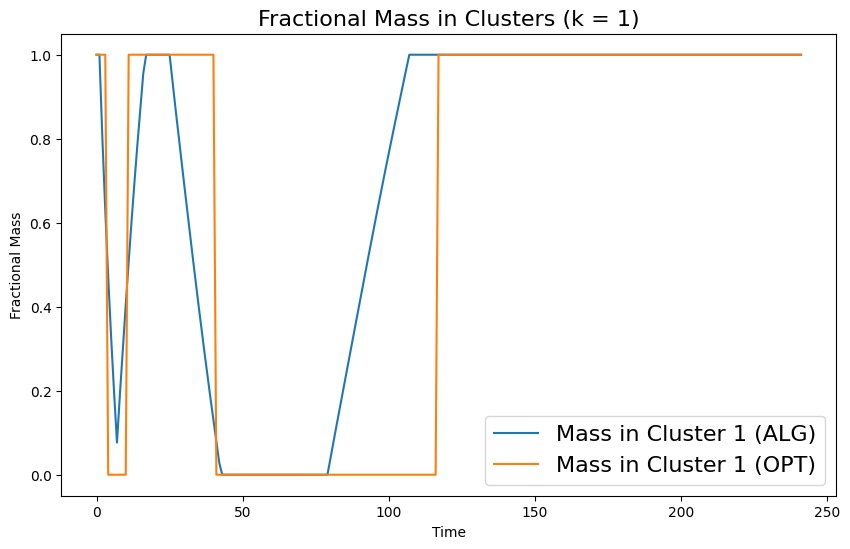

time 0
time 50
time 100
time 150
time 200
419.8471458155525


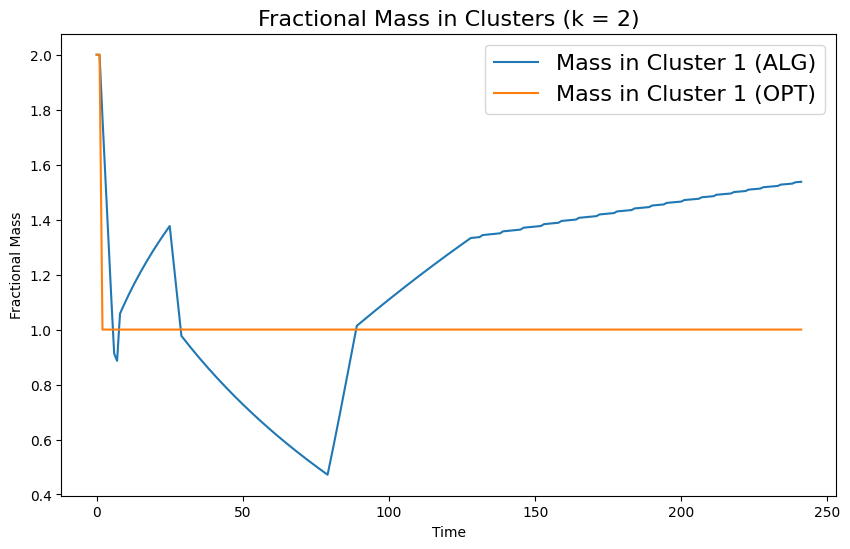

time 0
time 50
time 100
time 150
time 200
486.6335259199822


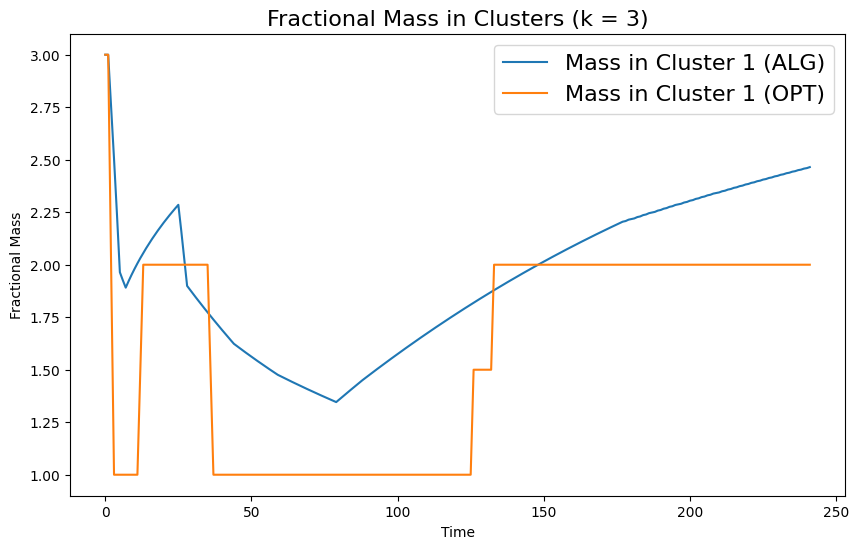

time 0
time 50
time 100
time 150
time 200
547.7388724615669


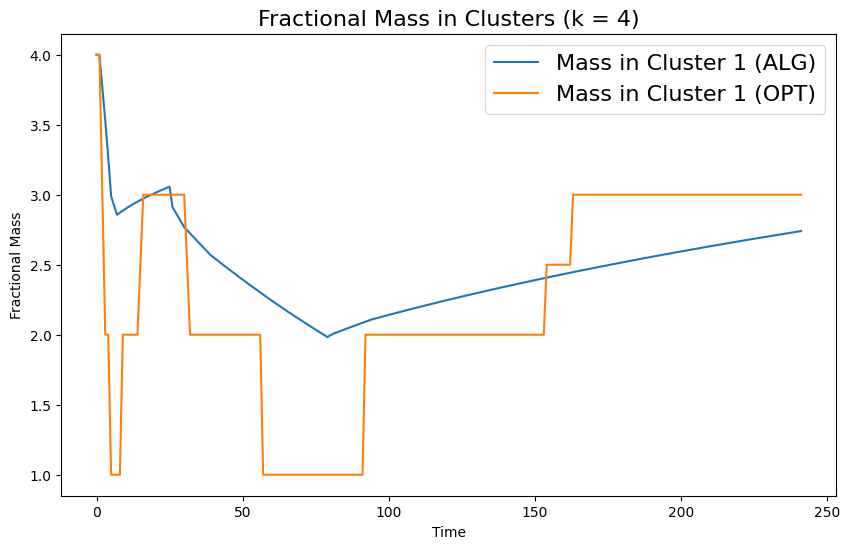

In [ ]:
metric_space = []
points_used = []
dict_used = {}
distances = []
distances_sorted = []
max_grad = 0

for k in [1,2,3,4]:
  weight_shifts(20,k,243,3,0.2,42,0)


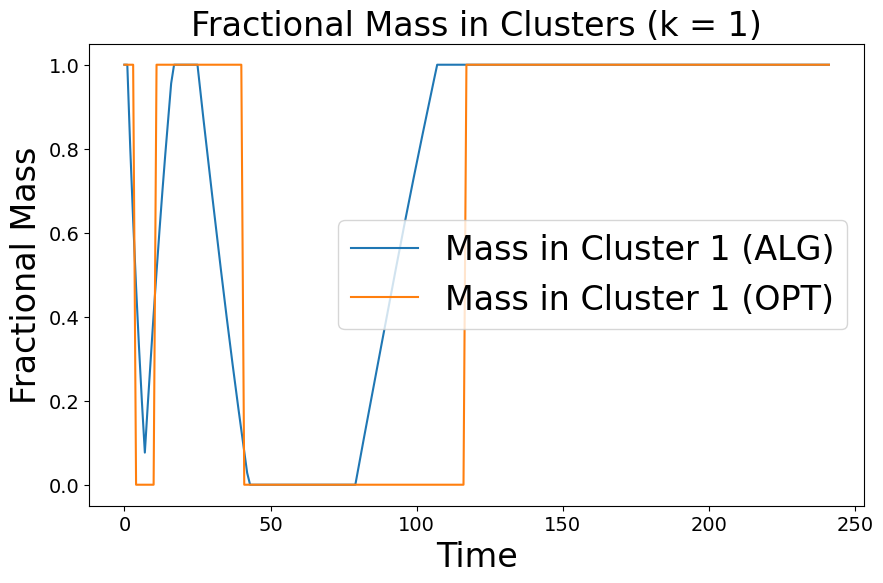

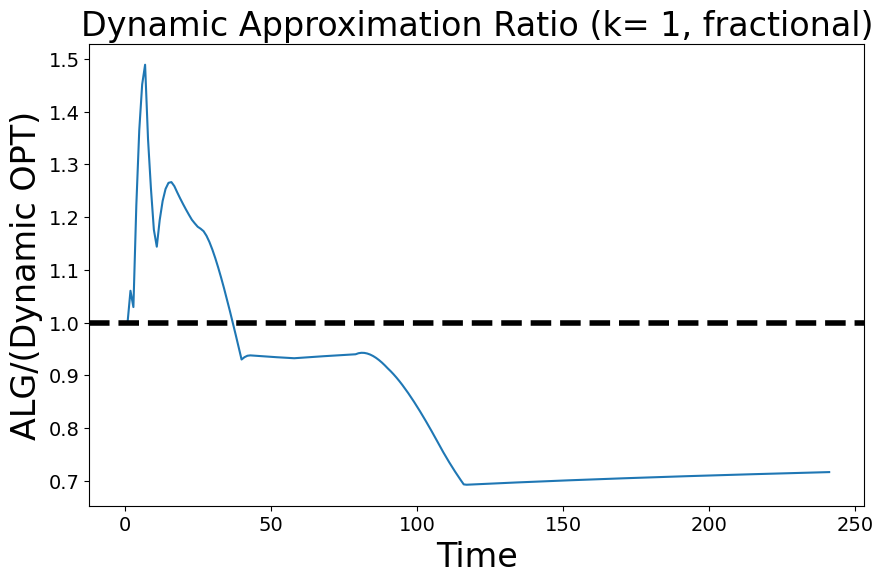

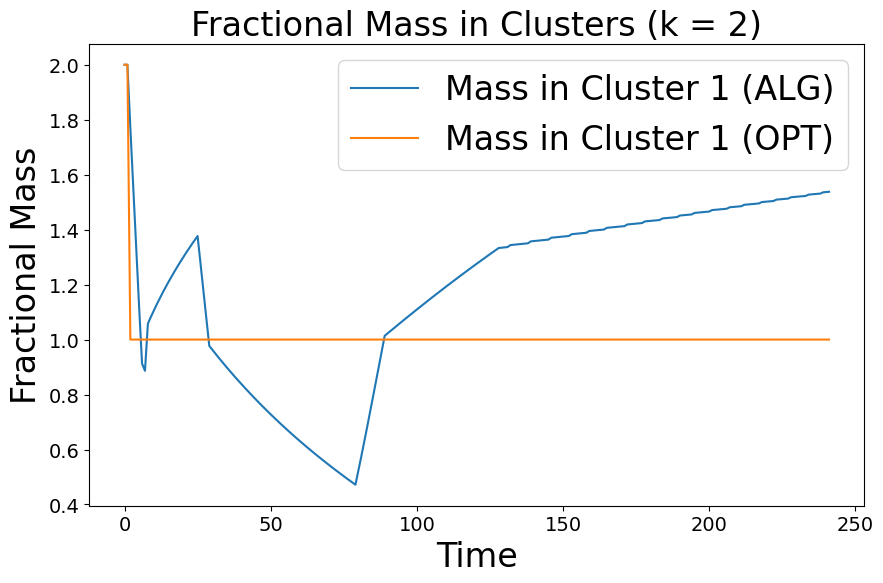

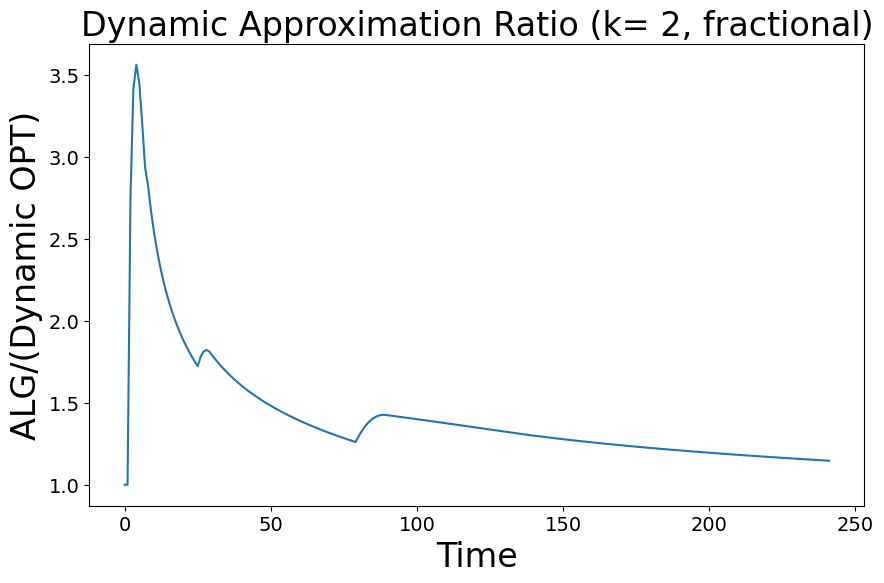

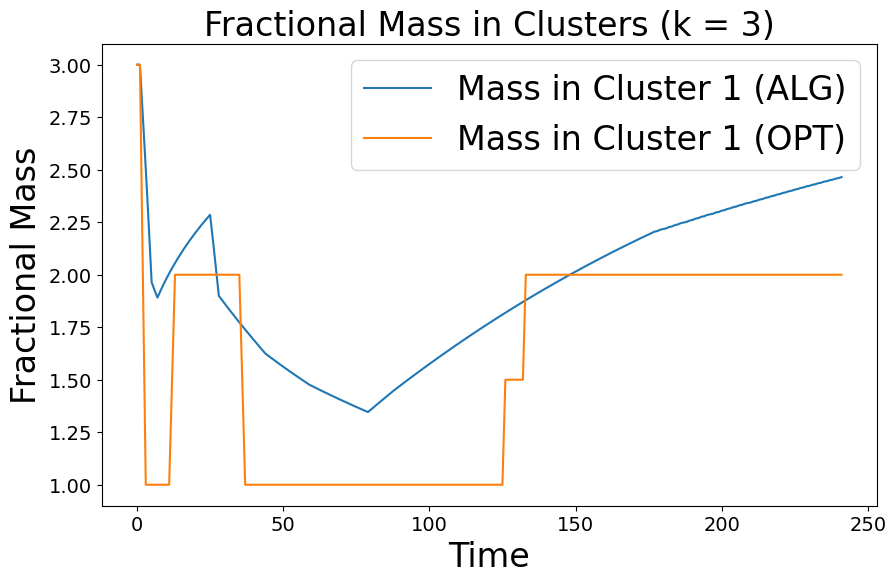

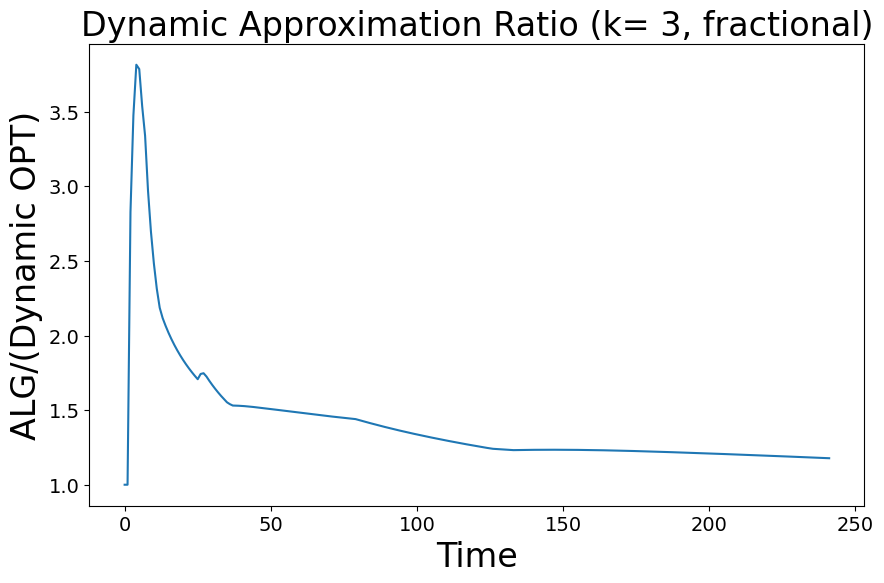

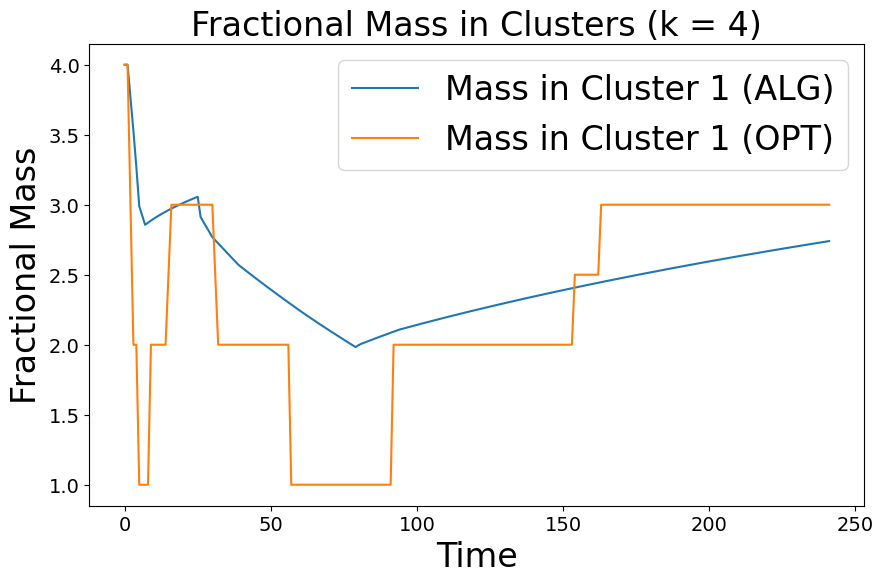

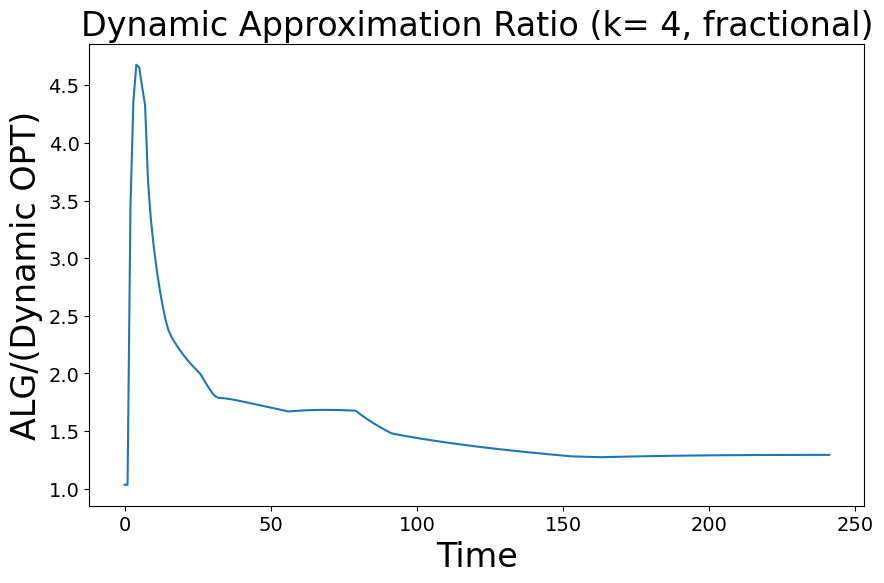

In [ ]:
for k in [1,2,3,4]:
  for f in [0]:
    text = "Deterministic"
    if (f==1):
      text  ="Randomized"


    # Load weightshift-related arrays from base_dir
    total_1 = np.load(f"{base_dir}/weightshift_total_1{k}_{f}.npy")
    total_2 = np.load(f"{base_dir}/weightshift_total_2{k}_{f}.npy")
    total_1_g = np.load(f"{base_dir}/weightshift_total_1_g{k}_{f}.npy")
    total_2_g = np.load(f"{base_dir}/weightshift_total_2_g{k}_{f}.npy")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(total_1, label="Mass in Cluster 1 (ALG)")
    plt.plot(total_1_g, label="Mass in Cluster 1 (OPT)")
    plt.title("Fractional Mass in Clusters (k = {})".format(k), fontsize = global_size)
    plt.xlabel("Time", fontsize = global_size)
    plt.ylabel("Fractional Mass", fontsize =global_size)
    plt.xticks(fontsize = global_font)
    plt.yticks(fontsize = global_font)
    plt.legend(fontsize = global_size)
    plt.savefig(f"{base_dir_img}/weightshift_frac{k}_{f}.png")  # Save figure
    plt.show()

    # Load saved data
    alg_cost_over_time = np.load(f"{base_dir}/weightshift_alg_cost_over_time{k}_{f}.npy")
    gurobi_cost_over_time = np.load(f"{base_dir}/weightshift_gurobi_cost_over_time{k}_{f}.npy")

    # Calculate the ratio
    ratio = np.array(alg_cost_over_time) / np.array(gurobi_cost_over_time)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(ratio)
    if(k==1):
      plt.axhline(y=1, color='black', linestyle='--', linewidth=4)
    plt.title("Dynamic Approximation Ratio (k= {}, {})".format(k,"fractional"),fontsize= global_size)
    plt.xlabel("Time",fontsize = global_size)
    plt.xticks(fontsize = global_font)
    plt.yticks(fontsize = global_font)
    plt.ylabel("ALG/(Dynamic OPT)",fontsize = global_size)
    plt.savefig(f"{base_dir_img}/weightshift_ratio{k}_{f}.png")  # Save figure
    plt.show()


In [ ]:
## Scale changes




def scale_changes(n,count,base,k,max_per_round,T,seed,f):
  global distances
  global distances_sorted
  global metric_space
  global points_used
  global dict_used
  global max_grad
  max_grad = 0



  np.random.seed(seed)  # Set seed for reproducibility

  # Create the metric space with clusters at specified centers
  #2*np.random.rand(n//2, 2) * spread + np.array([0, 0])  -  np.array([spread,spread])

  metric_space = []
  for i in range(count):  # count clusters
      if(i==0):
        cluster =2*np.random.rand(n//count, 2) * 0.2 + np.array([0, 0])   -  np.array([0.2,0.2])   # Cluster around (0, 0)
        metric_space.extend(cluster)
      else:
        center_x = 10**(i-1)# Cluster center x-coordinate
        cluster = 2*np.random.rand(n//count, 2) * 0.2 + np.array([center_x, 0])    -  np.array([0.2,0.2])   # Cluster around (center_x, 0)
        metric_space.extend(cluster)

  metric_space = np.array(metric_space)

  cost = 0
  y = 0
  points_used = [0]*n
  dict_used = {}
  alg_output = 0
  selected_points_history = []
  instance_list = []
  alg_cost_over_time = []
  gurobi_cost_over_time = []
  index_list = []
  ground_set = [i for i in range(n)]
  distances = [[dist_metric(y, x) for x in ground_set] for y in ground_set]
  distances_sorted = [0]*n
  for i in range(n):
    temp_arr = [[distances[i][j],j] for j in range(n)]
    temp_arr.sort()
    distances_sorted[i] = temp_arr
  weight_list = []
  total_alg = [0]*count
  total_opt = [0]*count
  instance_count = [0]*n
  for i in range(count):
    total_alg[i] = []
    total_opt[i]= []
  time_start = time.time()
  gurobi_opt = 0
  for t in range(T):
      if(t%50==0):
        print("time",t)

      index = 3
      if(t<=80):
        index = int(np.log(t+1)/np.log(base)  - 1e-6 )%count

      selected_indices = [index*10+i for i in range(10)]
      instance_list.append(selected_indices)




      weights = [1]*len(selected_indices)

      selected_centers,assignments,local_opt_cost =  gurobi_k_median(ground_set,weights,selected_indices,distances,k)
      #gurobi_opt = [ground_set[i] for i in selected_centers]
      weight_list.append(local_opt_cost)




      selected_points_history.append(metric_space[selected_indices])

      if(t==0):
        if(f==0):
          y,alg_output = det_online_k_median(selected_indices,y,t,k)
        else:
          y,alg_output = rand_online_k_median(selected_indices,y,t,k)
      else:

        local_alg_cost = k_median_cost(selected_indices,weights,y)
        cost+= local_alg_cost/local_opt_cost

        alg_cost_over_time.append(cost)
        if(f==0):
          y,alg_output = det_online_k_median(selected_indices,y,t,k)
        else:
          y,alg_output = rand_online_k_median(selected_indices,y,t,k)

      if(t>0):
        index_list.append(index)
        gurobi_opt, gurobi_cost= exp_gurobi_frac_benchmark(instance_list,weight_list,ground_set,distances,k)
        gurobi_cost_over_time.append(gurobi_cost)

        for j in range(count):
          total_alg[j].append(sum([y[i][1] for i in range(len(y)) if y[i][0]//10 == j]))
          total_opt[j].append(sum([gurobi_opt[i][1] for i in range(len(gurobi_opt)) if gurobi_opt[i][0]//10 == j]))



  np.save(f"{base_dir}/scalechange_gurobi_total_{k}_{f}_{T}f.npy", total_opt)
  np.save(f"{base_dir}/scalechange_alg_total_{k}_{f}_{T}f.npy", total_alg)
  np.save(f"{base_dir}/scalechange_alg_cost_over_time_{k}_{f}_{T}f.npy", alg_cost_over_time)
  np.save(f"{base_dir}/scalechange_gurobi_cost_over_time_{k}_{f}_{T}f.npy", gurobi_cost_over_time)
  np.save(f"{base_dir}/scalechange_index_list_{k}_{f}_{T}f.npy", index_list)


  import matplotlib.pyplot as plt
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed

  length =  len(index_list)  # Number of time steps

  # Generate the data series based on the log2 rule
  alg_vals = [total_alg[index_list[t+1]][t] for t in range(length-1)]
  opt_vals =  [total_opt[index_list[t+1]][t] for t in range(length-1)]
  #print(optvals)



  plt.plot(alg_vals, label = "ALG")
  plt.plot(opt_vals, label = "OPT")
  plt.title("Total fraction in New Cluster Over Time (k= {})".format(k),fontsize = 16)
  plt.xlabel("Time",fontsize = 16)
  plt.ylabel("Total Fraction",fontsize = 16)
  plt.legend(fontsize = 16)

  plt.show()


  # Calculate the ratio
  ratio = np.array(alg_cost_over_time) / np.array(gurobi_cost_over_time)
  print("ratios",ratio[-100:])
  print("alg",alg_cost_over_time[-100:])
  print("opt", gurobi_cost_over_time[-100:])
  #for i in range(len(ratio)):
  #  print(alg_cost_over_time[i], gurobi_cost_over_time[i])
  #ratio = np.array(alg_cost_over_time[-100:]) / np.array(gurobi_cost_over_time[-100:])
  # Create the plot
  plt.figure(figsize=(10, 6))
  plt.plot(ratio)

  # Customize the plot
  plt.title("Dynamic Approximation Ratio (k= {}, {})".format(k, "fractional"),fontsize = 16)
  plt.xlabel("Time",fontsize = 16)
  plt.ylabel("ALG/(Dynamic OPT)",fontsize = 16)

  # Show the plot
  plt.show()





time 0
time 50
time 100
time 150
time 200
time 250
time 300
time 350
time 400
time 450
time 500
time 550
time 600
time 650
time 700
time 750
time 800
time 850
time 900
time 950
time 1000
time 1050
time 1100
time 1150
time 1200
time 1250
time 1300
time 1350
time 1400
time 1450
time 1500
time 1550
time 1600
time 1650
time 1700
time 1750
time 1800
time 1850
time 1900
time 1950
time 2000
time 2050
time 2100
time 2150
time 2200
time 2250
time 2300
time 2350
time 2400
time 2450
time 2500
time 2550
time 2600
time 2650
time 2700
time 2750
time 2800
time 2850
time 2900
time 2950
time 3000
time 3050
time 3100
time 3150
time 3200
time 3250
time 3300
time 3350
time 3400
time 3450
time 3500
time 3550
time 3600
time 3650
time 3700
time 3750
time 3800
time 3850
time 3900
time 3950
time 4000
time 4050
time 4100
time 4150
time 4200
time 4250
time 4300
time 4350
time 4400
time 4450
time 4500
time 4550
time 4600
time 4650
time 4700
time 4750
time 4800
time 4850
time 4900
time 4950
time 5000
time 5050
tim

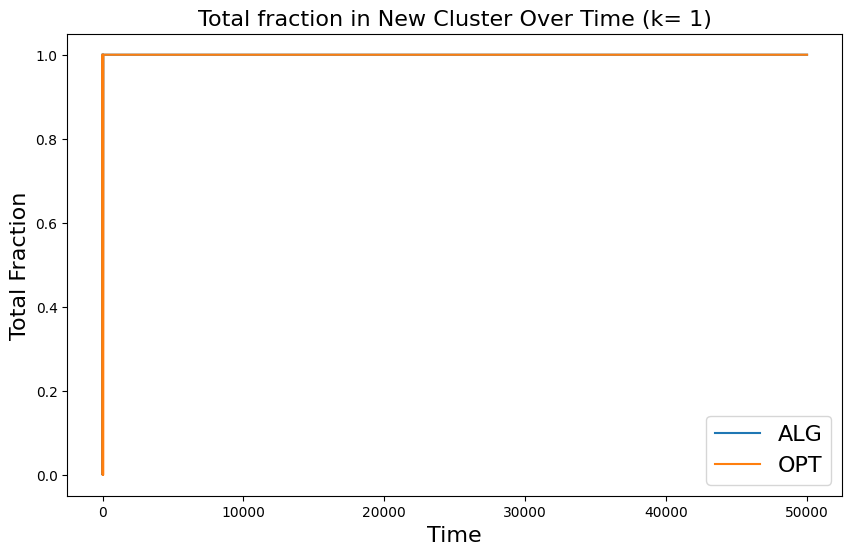

ratios [0.70389499 0.70389764 0.70390028 0.70390293 0.70390557 0.70390822
 0.70391086 0.70391351 0.70391615 0.70391879 0.70392144 0.70392408
 0.70392673 0.70392937 0.70393201 0.70393466 0.7039373  0.70393995
 0.70394259 0.70394523 0.70394788 0.70395052 0.70395316 0.70395581
 0.70395845 0.70396109 0.70396374 0.70396638 0.70396902 0.70397167
 0.70397431 0.70397695 0.7039796  0.70398224 0.70398488 0.70398753
 0.70399017 0.70399281 0.70399546 0.7039981  0.70400074 0.70400338
 0.70400603 0.70400867 0.70401131 0.70401395 0.7040166  0.70401924
 0.70402188 0.70402452 0.70402717 0.70402981 0.70403245 0.70403509
 0.70403773 0.70404038 0.70404302 0.70404566 0.7040483  0.70405094
 0.70405359 0.70405623 0.70405887 0.70406151 0.70406415 0.70406679
 0.70406944 0.70407208 0.70407472 0.70407736 0.70408    0.70408264
 0.70408528 0.70408793 0.70409057 0.70409321 0.70409585 0.70409849
 0.70410113 0.70410377 0.70410641 0.70410905 0.70411169 0.70411433
 0.70411698 0.70411962 0.70412226 0.7041249  0.70412754

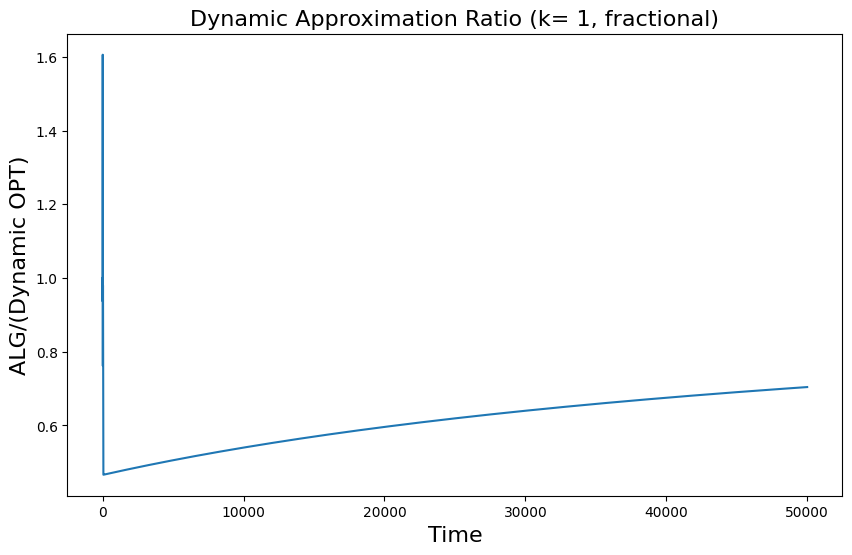

In [ ]:
metric_space = []
points_used = []
dict_used = {}
distances = []
distances_sorted = []
max_grad = 0
scale_changes(50,5,3,1,10,50000,42,1)
#scale_changes(50,5,3,2,10,50000,42,1)
#scale_changes(50,5,3,3,10,50000,42,1)

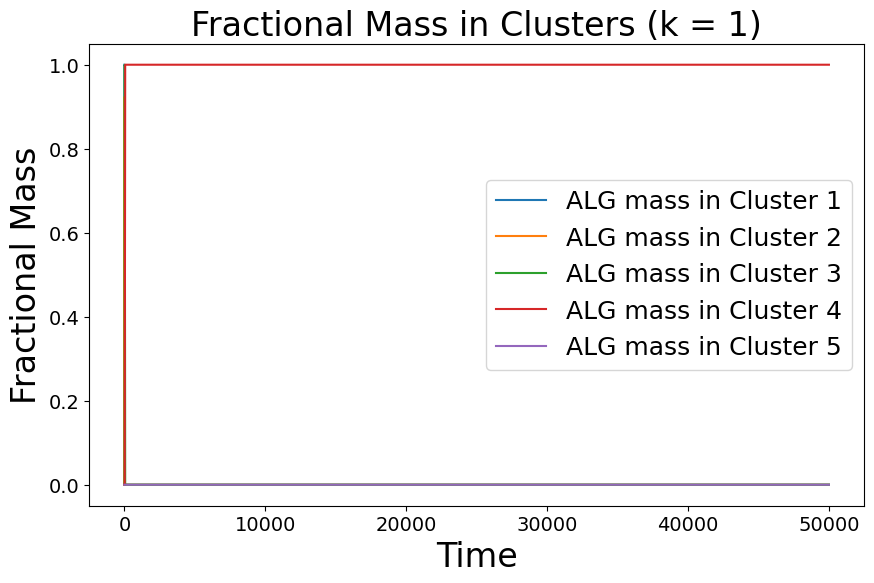

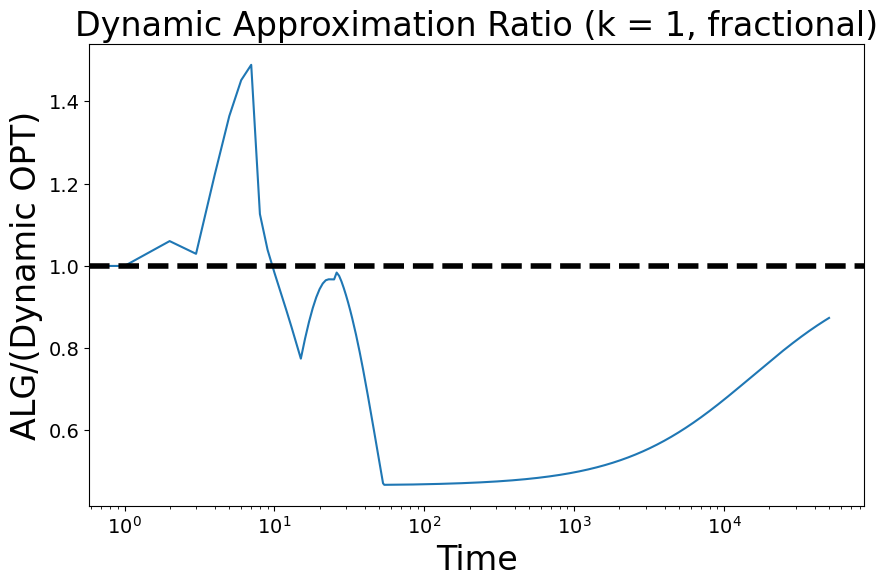

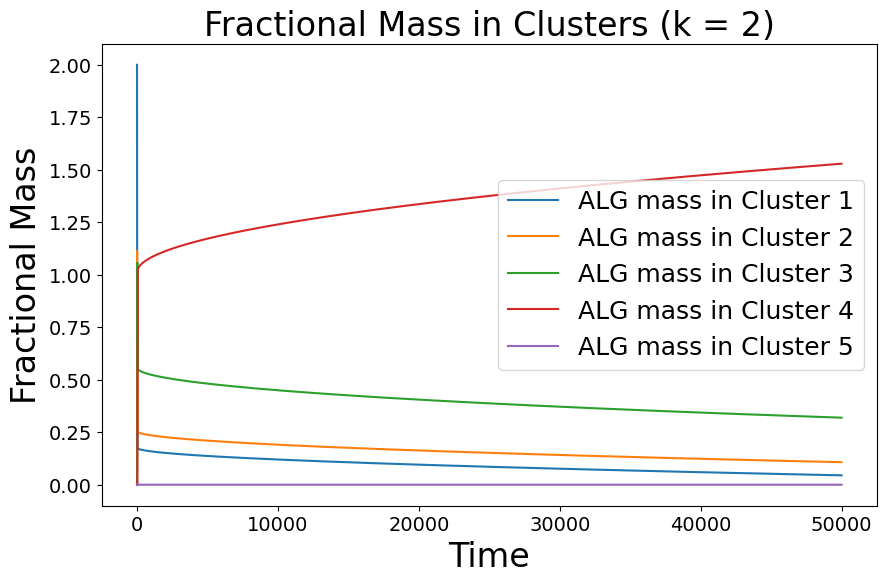

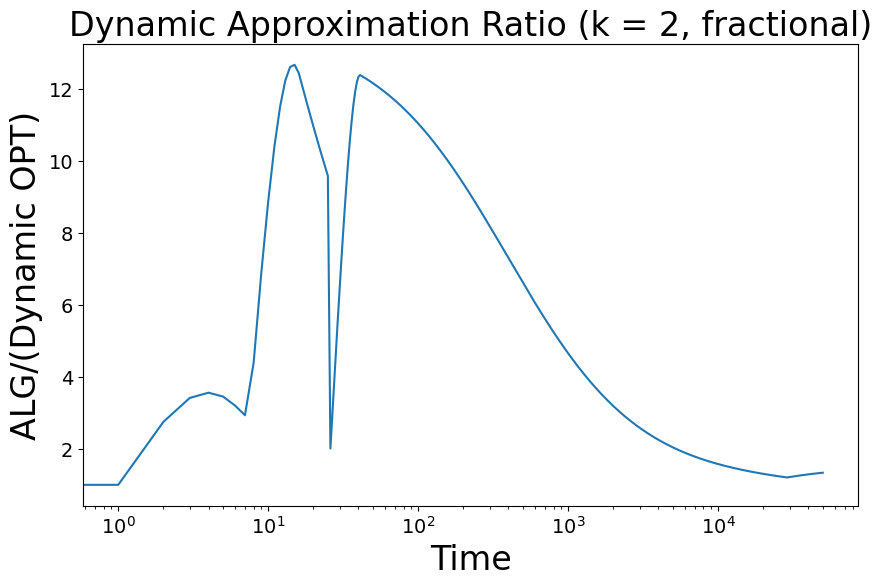

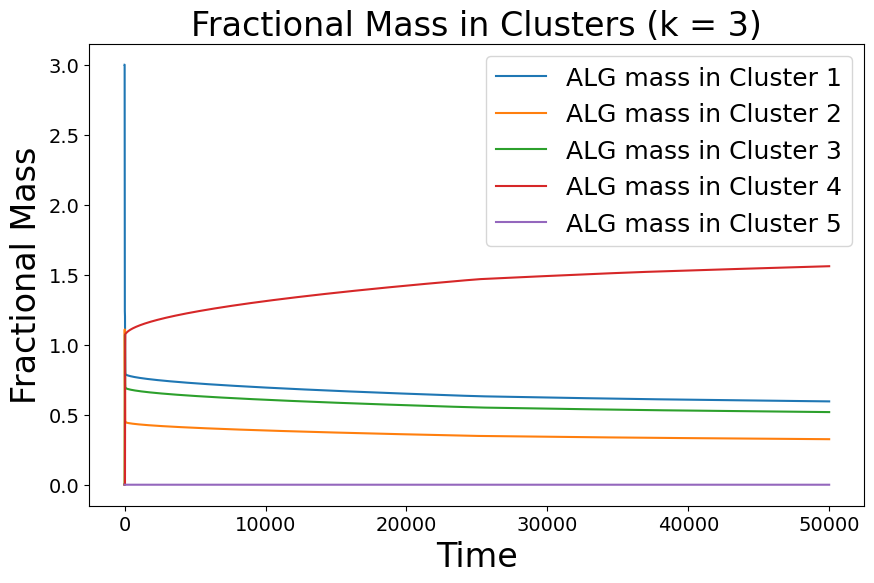

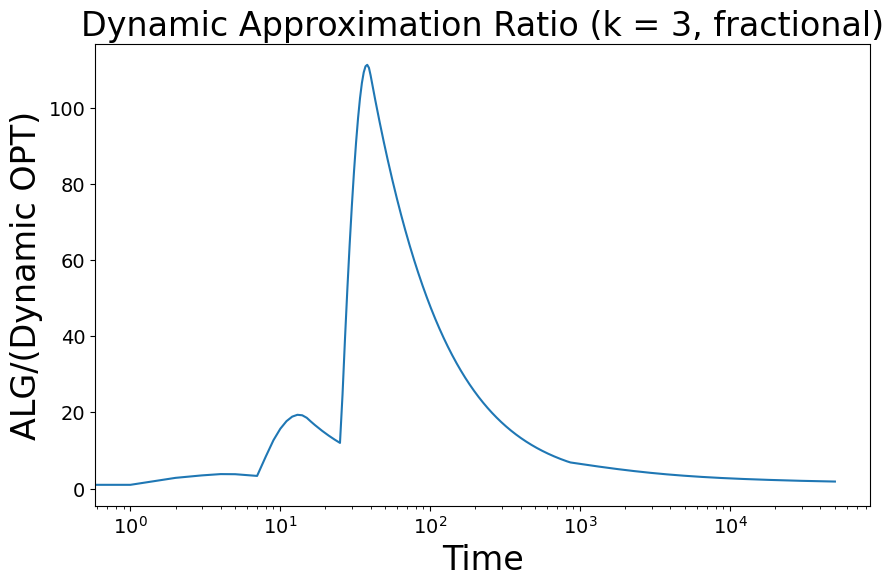

In [10]:
T = 50000
for k in [1,2,3]:
  for f in [1]:
    text = "Deterministic"
    if (f==1):
      text  ="Randomized"
    total_opt = np.load(f"{base_dir}/scalechange_gurobi_total_{k}_{f}_{T}f.npy")
    total_alg = np.load(f"{base_dir}/scalechange_alg_total_{k}_{f}_{T}f.npy")
    alg_cost_over_time = np.load(f"{base_dir}/scalechange_alg_cost_over_time_{k}_{f}_{T}f.npy")
    gurobi_cost_over_time = np.load(f"{base_dir}/scalechange_gurobi_cost_over_time_{k}_{f}_{T}f.npy")
    index_list = np.load(f"{base_dir}/scalechange_index_list_{k}_{f}_{T}f.npy")
    length =  len(index_list)  # Number of time steps

    # Generate the data series based on the log2 rule
    alg_vals = [0]*5
    for i in range(5):
      alg_vals[i] = [total_alg[i][t] for t in range(length-1)]
    #opt_vals =  [total_opt[index_list[t+1]][t] for t in range(length-1)]
    plt.figure(figsize=(10, 6))
    for i in range(5):
      plt.plot(alg_vals[i], label = "ALG mass in Cluster {}".format(i+1))
    #plt.plot(opt_vals, label = "OPT")
    plt.title("Fractional Mass in Clusters (k = {})".format(k),fontsize = global_size)
    plt.xlabel("Time",fontsize = global_size)
    plt.ylabel("Fractional Mass",fontsize = global_size)
    plt.xticks(fontsize = global_font)
    plt.yticks(fontsize = global_font)
    plt.legend(fontsize = global_size-6)

    plt.savefig(f"{base_dir_img}/scalechange_frac{k}_{f}temp.png")  # Save figure
    plt.show()


    # Calculate the ratio-
    ratio = np.array(alg_cost_over_time) / np.array(gurobi_cost_over_time)
    #ratio = np.array(alg_cost_over_time[-100:]) / np.array(gurobi_cost_over_time[-100:])
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.xticks(fontsize = global_font)
    plt.yticks(fontsize = global_font)
    plt.xscale("log")
    plt.plot(ratio)

    # Customize the plot
    # Add horizontal line at y = 1
    if(k==1):
      plt.axhline(y=1, color='black', linestyle='--', linewidth=4)
    plt.title("Dynamic Approximation Ratio (k = {}, {})".format(k,"fractional"),fontsize = global_size)
    plt.xlabel("Time",fontsize = global_size)
    plt.ylabel("ALG/(Dynamic OPT)",fontsize = global_size)

    plt.savefig(f"{base_dir_img}/scalechange_ratio{k}_{f}temp.png")  # Save figure
    # Show the plot
    plt.show()



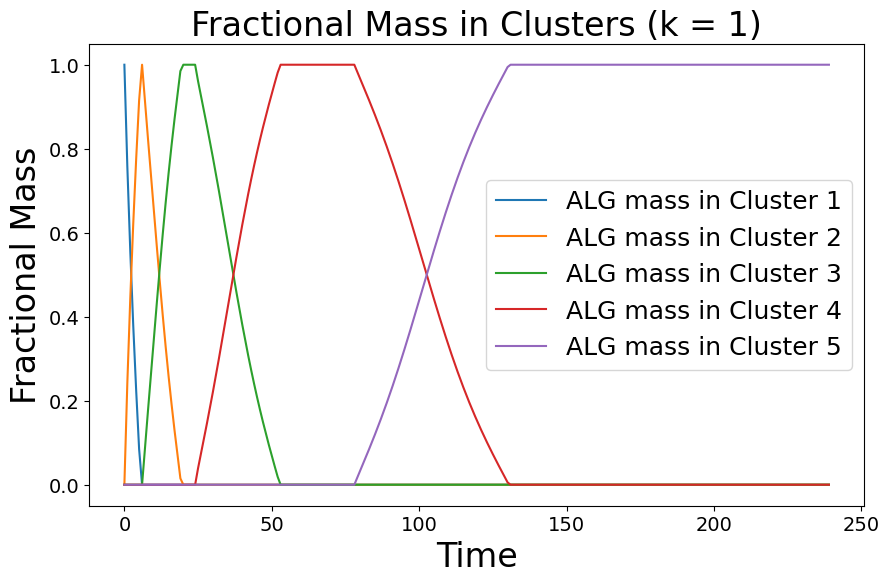

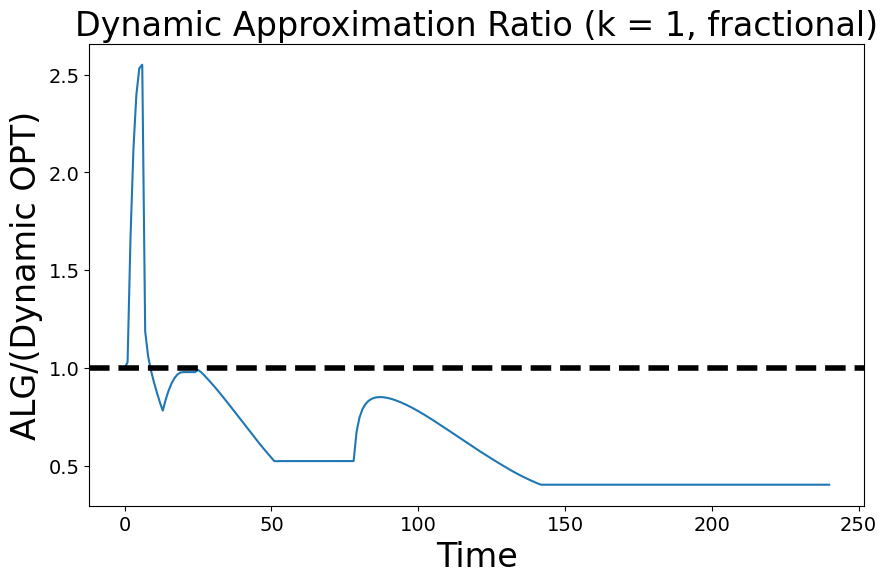

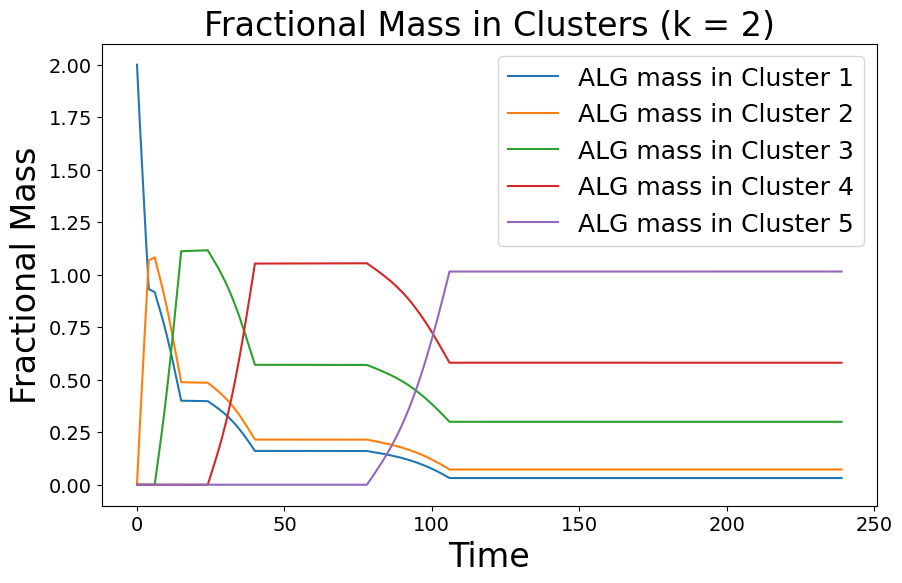

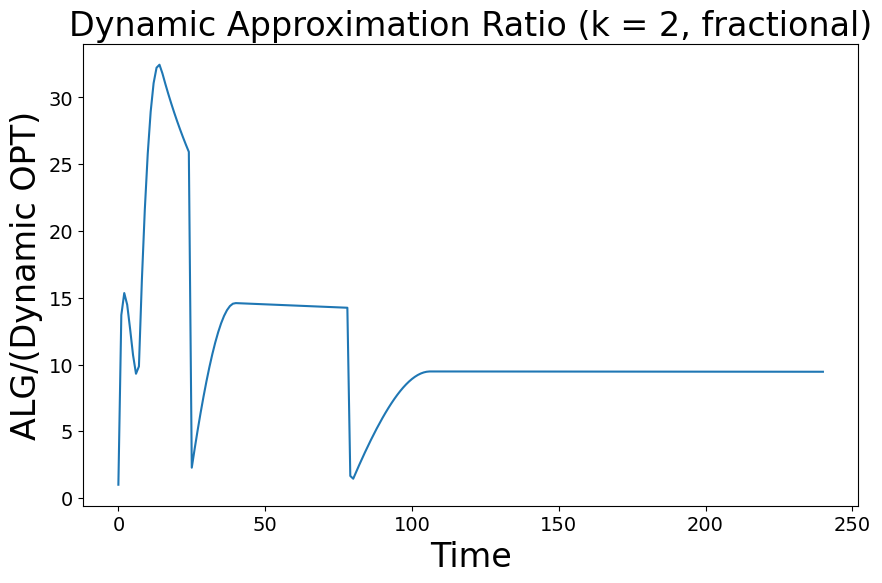

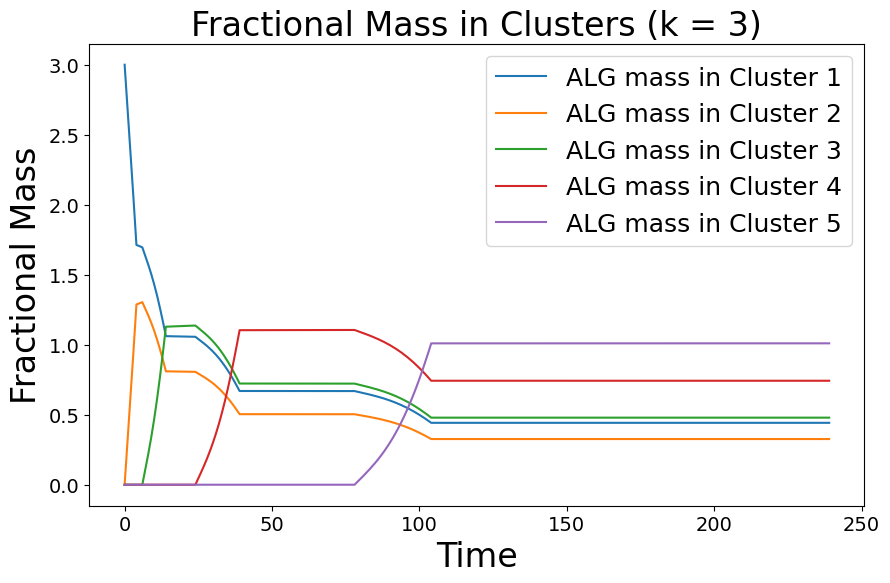

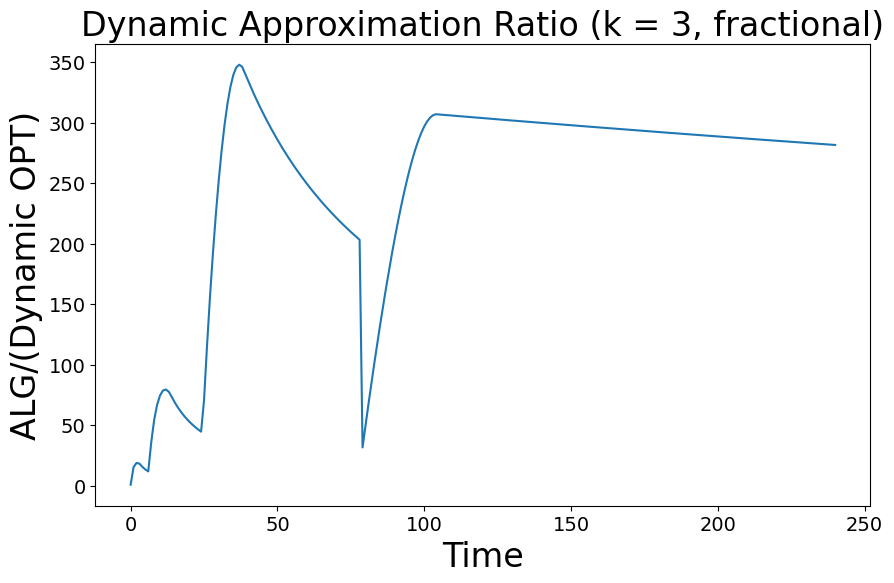

In [ ]:
T = 50000
for k in [1,2,3]:
  for f in [1]:
    text = "Deterministic"
    if (f==1):
      text  ="Randomized"
    total_opt = np.load(f"{base_dir}/scalechange_gurobi_total_{k}_{f}.npy")
    total_alg = np.load(f"{base_dir}/scalechange_alg_total_{k}_{f}.npy")
    alg_cost_over_time = np.load(f"{base_dir}/scalechange_alg_cost_over_time_{k}_{f}.npy")
    gurobi_cost_over_time = np.load(f"{base_dir}/scalechange_gurobi_cost_over_time_{k}_{f}.npy")
    index_list = np.load(f"{base_dir}/scalechange_index_list_{k}_{f}.npy")
    length =  len(index_list)  # Number of time steps

    # Generate the data series based on the log2 rule
    alg_vals = [0]*5
    for i in range(5):
      alg_vals[i] = [total_alg[i][t] for t in range(length-1)]
    #opt_vals =  [total_opt[index_list[t+1]][t] for t in range(length-1)]
    plt.figure(figsize=(10, 6))
    for i in range(5):
      plt.plot(alg_vals[i], label = "ALG mass in Cluster {}".format(i+1))
    #plt.plot(opt_vals, label = "OPT")
    plt.title("Fractional Mass in Clusters (k = {})".format(k),fontsize = global_size)
    plt.xlabel("Time",fontsize = global_size)
    plt.ylabel("Fractional Mass",fontsize = global_size)
    plt.xticks(fontsize = global_font)
    plt.yticks(fontsize = global_font)
    plt.legend(fontsize = global_size-6)

    plt.savefig(f"{base_dir_img}/scalechange_frac{k}_{f}.png")  # Save figure
    plt.show()


    # Calculate the ratio-
    ratio = np.array(alg_cost_over_time) / np.array(gurobi_cost_over_time)
    #ratio = np.array(alg_cost_over_time[-100:]) / np.array(gurobi_cost_over_time[-100:])
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.xticks(fontsize = global_font)
    plt.yticks(fontsize = global_font)
    plt.plot(ratio)

    # Customize the plot
    # Add horizontal line at y = 1
    if(k==1):
      plt.axhline(y=1, color='black', linestyle='--', linewidth=4)
    plt.title("Dynamic Approximation Ratio (k = {}, {})".format(k,"fractional"),fontsize = global_size)
    plt.xlabel("Time",fontsize = global_size)
    plt.xticks(fontsize = global_font)
    plt.yticks(fontsize = global_font)
    plt.ylabel("ALG/(Dynamic OPT)",fontsize = global_size)

    plt.savefig(f"{base_dir_img}/scalechange_ratio{k}_{f}.png")  # Save figure
    # Show the plot
    plt.show()

